# Commonvoice Pipeline Profiling Analysis

### Prerequisites

None. Exemplary logs are loaded by default. Experiments were run on:

* Storage: CEPH SSDs
* CPU: Intel Xeon E5-2630 v3 8x@2.4GHz
* Image: ubuntu-18.04-lts/Openstack
* Memory: 20GB DDR4

All plots that are not saved with the `save_fig` function were not used in the paper, but may provide a close-up look on specific values.

### Meta information

* "first" preprocessing step of listing the files was removed (check `commonvoice_demo.py`) because it did not affect performance in our tests. This should be reintroduced when simulating distributed training, e.g., federated learning, where getting the file locations can actually affect performance


* Data size of all training samples: 0.251GB (`size-script.py` on CEPH)
* Amount of `.flac` files in the training set: 12717 (`cat train.tsv | wc -l` - 1 because of the header)
* Avg. filesize: `0.0197` MB
* Sample sizes (rounded to second decimal):
    * `0500:    9.86 MB` 
    * `1000:   19.71 MB`
    * `2000:   39.43 MB`
    * `4000:   78.85 MB`
    * `8000:  157.71 MB`
    * `12717: 250.71 MB`

## Dataset General Information

In [14]:
full_dataset_filecount = 12717
for sample_size in [500, 1000, 2000, 4000, 8000]:
    print(f"{sample_size} of total: {round(sample_size / full_dataset_filecount * 100, 2)}%")

500 of total: 3.93%
1000 of total: 7.86%
2000 of total: 15.73%
4000 of total: 31.45%
8000 of total: 62.91%


In [1]:
%load_ext autoreload
%autoreload 2
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import ticker
from typing import List
# adding previous directory for easier use of library
import sys
sys.path.append('../')
from notebookhelper import show_values_on_bars, save_figure
from presto.analysis import StrategyAnalysis \
                          , strat_analysis_from_csv

pd.set_option('display.max_rows', 200)
plotting_context = "paper"
plotting_palette = "deep"
font_scale = 1.3
sns.set(font_scale=font_scale, context=plotting_context, palette=plotting_palette)
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

In [2]:
local_fig_dir = "commonvoice-pipeline"
def save_fig(name, file_type='pdf'):
    save_figure(name, local_fig_dir=local_fig_dir, file_type=file_type)

home_path = "../logs/commonvoice"
path_to_cum_df = f"{home_path}/commonvoice_2021-04-19-16:21:24_cum-df_samples-500-1000-2000-4000-8000-12717_threads-1-2-4-8.csv"
path_to_cum_dstat_df = f"{home_path}/commonvoice_2021-04-19-16:21:24_cum-dstat-df_samples-500-1000-2000-4000-8000-12717_threads-1-2-4-8.csv"
sampling_tag = ""

analysis = strat_analysis_from_csv(path_to_cum_dstat_df = path_to_cum_dstat_df
                                 , path_to_cum_df = path_to_cum_df)
cum_dstat_df = analysis.to_cum_dstat_df()
cum_df       = analysis.to_cum_df()
summary      = analysis.summary()
strategies   = summary.strategy.unique()
print(strategies)
strategies_renamed = ["unprocessed", "decode-mp3", "full"] #"spectrogram"]

['0-fully-online' '2-read-and-decode-mp3' '3-convert-to-spectrogram']


In [3]:
cum_df.head(5)

,offline_processing_and_save_time_s,shard_count,thread_count,shard_cum_size_MB,sample_count,online_processing_time_s,throughput_sps,runs_count,runs_total,ueid,split_name,creation_timestamp
0,0.0,1,1,0.0,500,21.963967,22.764558,0,5,0725be,0-fully-online,2021-04-19-16:21:24
1,0.0,1,1,0.0,500,18.655786,26.801337,1,5,0725be,0-fully-online,2021-04-19-16:21:24
2,0.0,1,1,0.0,500,18.988259,26.332061,2,5,0725be,0-fully-online,2021-04-19-16:21:24
3,0.0,1,1,0.0,500,18.742784,26.676934,3,5,0725be,0-fully-online,2021-04-19-16:21:24
4,0.0,1,1,0.0,500,19.672406,25.416311,4,5,0725be,0-fully-online,2021-04-19-16:21:24


In [4]:
cum_dstat_df.head(5)

,rel_time_s,disk_read_mbs,disk_write_mbs,net_read_mbs,net_write_mbs,run,sample_count,shard_count,thread_count,ueid,split_name,creation_timestamp
0,0.0,0.007932,0.007101,0.000000,0.000000,1,500,1,1,0725be,0-fully-online,2021-04-19-16:21:24
1,1.0,0.000000,0.000000,2.961049,0.037529,1,500,1,1,0725be,0-fully-online,2021-04-19-16:21:24
2,2.0,0.000000,0.000000,0.552777,0.044133,1,500,1,1,0725be,0-fully-online,2021-04-19-16:21:24
3,3.0,0.000000,0.000000,0.569625,0.048420,1,500,1,1,0725be,0-fully-online,2021-04-19-16:21:24
4,4.0,0.004096,0.000000,0.526678,0.042096,1,500,1,1,0725be,0-fully-online,2021-04-19-16:21:24


## 0. Experiment Information

### 0.1 Experiment Count
We define an experiment as profiling a materialization strategy (e.g., `0-fully-online`) with a certain sample count (e.g, `500`).

We replicated **every** experiment **5** times, that means we should have `5 * <mat-strategies> * <thread_count>` experiments for each sample size. The only exception is the full dataset preprocessing, which is ran with `thread_count = 8`.

`norm_thread_experiment_count` should be `5` for all.

Unfortunately the `ueid`s are based on the way the experiments were ran (in the python loop vs. bash loop), so we only count the rows, as each row in the `cum_df` dataframe is a single experiment.

In [5]:
experiment_count_dict = {
    "sample_count": []
  , "sample_experiment_count": []
  , "thread_count": []
  , "thread_experiment_count": []
  , "norm_thread_experiment_count": []
}

def get_experiment_count(df):
    '''Short helper'''
    return len(df.index)

def add_to_dict(sample_count, sample_experiment_count
              , thread_count, thread_experiment_count, norm_thread_experiment_count):
    '''Short helper'''
    experiment_count_dict["sample_count"] += [sample_count]
    experiment_count_dict["sample_experiment_count"] += [sample_experiment_count]
    experiment_count_dict["thread_count"] += [thread_count]
    experiment_count_dict["thread_experiment_count"] += [thread_experiment_count]
    experiment_count_dict["norm_thread_experiment_count"] += [norm_thread_experiment_count]

for sample_count in cum_df["sample_count"].unique():
    sample_experiment_count = get_experiment_count(cum_df.query(f'sample_count=={sample_count}'))
    for thread_count in cum_df.query(f'sample_count=={sample_count}')['thread_count'].unique():
        thread_experiment_count = get_experiment_count(cum_df.query(f'sample_count=={sample_count} and thread_count=={thread_count}'))
        norm_thread_experiment_count = thread_experiment_count / len(strategies)
        add_to_dict(sample_count, sample_experiment_count,
                    thread_count, thread_experiment_count, norm_thread_experiment_count)
        
experiment_count_df = pd.DataFrame.from_dict(experiment_count_dict)
experiment_count_df

,sample_count,sample_experiment_count,thread_count,thread_experiment_count,norm_thread_experiment_count
0,500,60,1,15,5.0
1,500,60,2,15,5.0
2,500,60,4,15,5.0
3,500,60,8,15,5.0
4,1000,60,1,15,5.0
5,1000,60,2,15,5.0
6,1000,60,4,15,5.0
7,1000,60,8,15,5.0
8,2000,60,1,15,5.0
9,2000,60,2,15,5.0


# 1. Storage Consumption Analysis

## 1.1 Uncompressed dataset storage consumption compared the different strategies

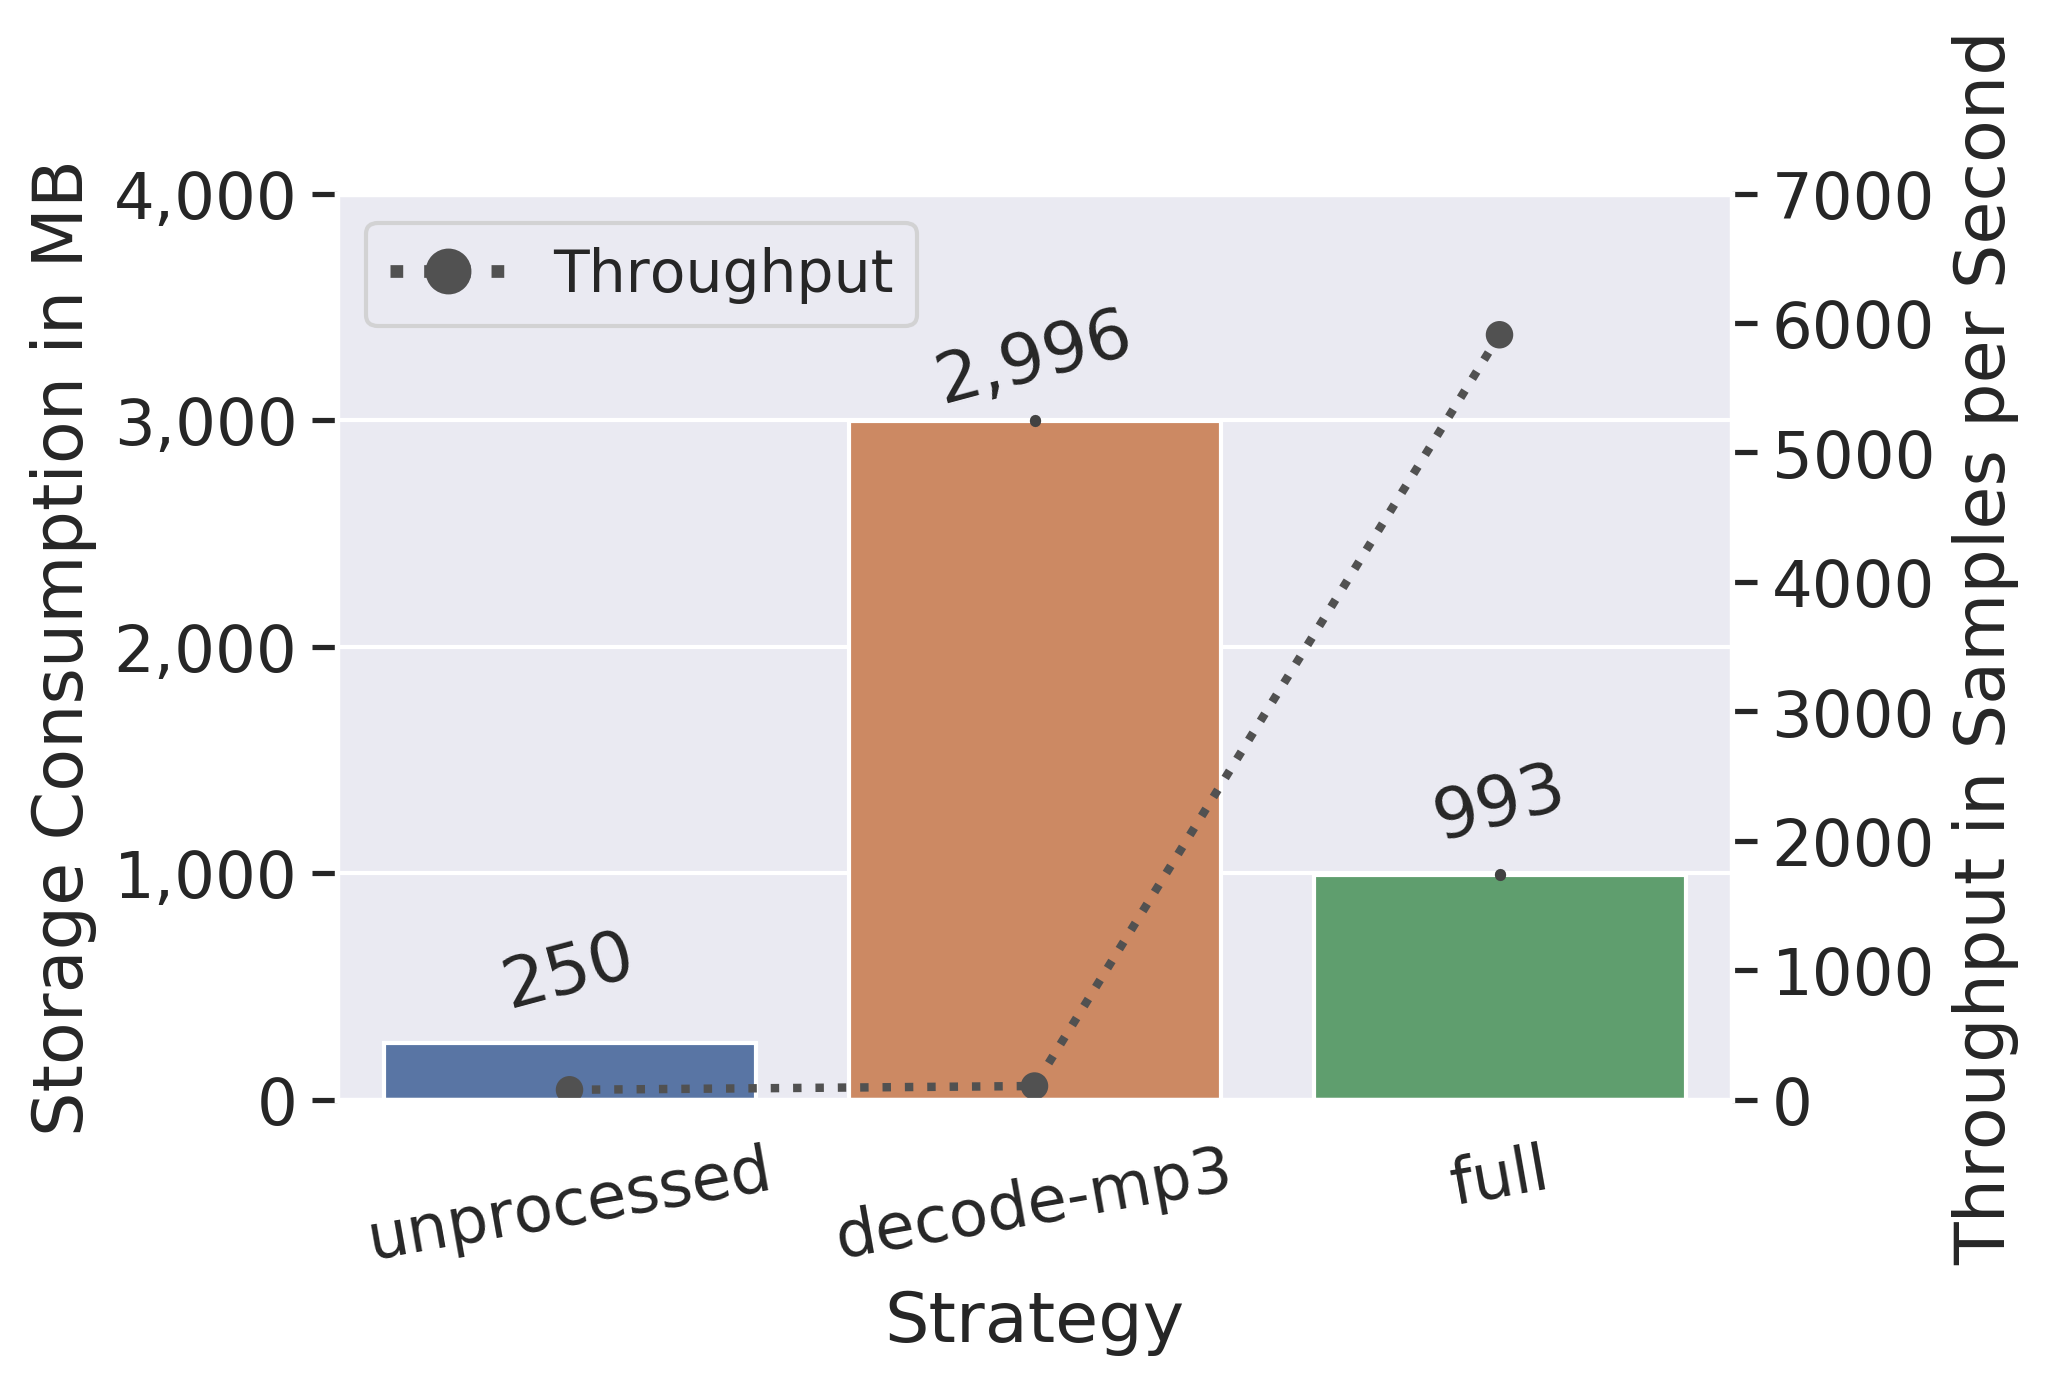

In [6]:
sample_size_mb_dict = {
    "500": 9.86
  , "1000": 19.71
  , "2000": 39.43
  , "4000": 78.85
  , "8000": 157.71
  , "12717": 250.71
}

storage_consumption_comparison = {
    "storage_consumption": []
  , "sample_count": []
  , "strategy": []
}

def add_to_dict(size, sample_count, label):
    '''Short helper'''
    storage_consumption_comparison["storage_consumption"] += [size]
    storage_consumption_comparison["sample_count"] += [sample_count]
    storage_consumption_comparison["strategy"] += [label]
    
for sample_count in cum_df.sample_count.unique():
    for i, strategy in enumerate(strategies):
        shard_sizes_mb = cum_df.query(f"split_name=='{strategy}' and sample_count=={sample_count}")["shard_cum_size_MB"].to_numpy()
        for size_mb in shard_sizes_mb:
            if i == 0: # i.e., unprocessed
                size_mb = sample_size_mb_dict[str(sample_count)]
            add_to_dict(size = size_mb
                      , sample_count = sample_count
                      , label = strategies[i])

storage_df = pd.DataFrame(storage_consumption_comparison)

from matplotlib.lines import Line2D

throughput_color = "#515151"
marker = 'o'
linestyle = ":"

sns.set(font_scale=1.4)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()


## throughput plot
plot2 = sns.pointplot(x="split_name", y="throughput_sps",
                    data=cum_df.query(f"sample_count=={np.max(cum_df.sample_count.unique())}"),
                    ax=ax2, scale=0.75, color=throughput_color, linestyles=linestyle, ci=0.95, marker='o')

plot2.set(ylabel="Throughput in Samples per Second")
plot2.set_xticklabels(
    strategies_renamed
  , rotation=20
)
ax2.grid(False)
legend_elements = [Line2D([0], [0], marker=marker, markersize=10, color=throughput_color, lw=3.05, label='Throughput', linestyle=linestyle)]
ax2.legend(handles=legend_elements, loc="upper left", prop={'size': 14})
plot2.set(ylim=(0, 7000))          


plot = sns.barplot(
        x="strategy",
        y="storage_consumption",
        data=storage_df.query(f"sample_count=={np.max(cum_df.sample_count.unique())}"),
        ax=ax1
    )
plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
show_values_on_bars(plot, h_v="v", space=300, rotation=15)
plot.set(ylabel="Storage Consumption in MB", xlabel="Strategy")
plot.set(ylim=(0, 4000))

# FuncFormatter can be used as a decorator
@ticker.FuncFormatter
def major_formatter(value, pos):
    return re.sub(r'(?<!^)(?=(\d{3})+$)', r',', str(value)[0:-2])

plot.yaxis.set_major_formatter(major_formatter)
save_fig("storage-consumption")

# 2. Preprocessing Time Anaylsis

## 2.1 Preprocessing Time Plots

[(0, 300)]

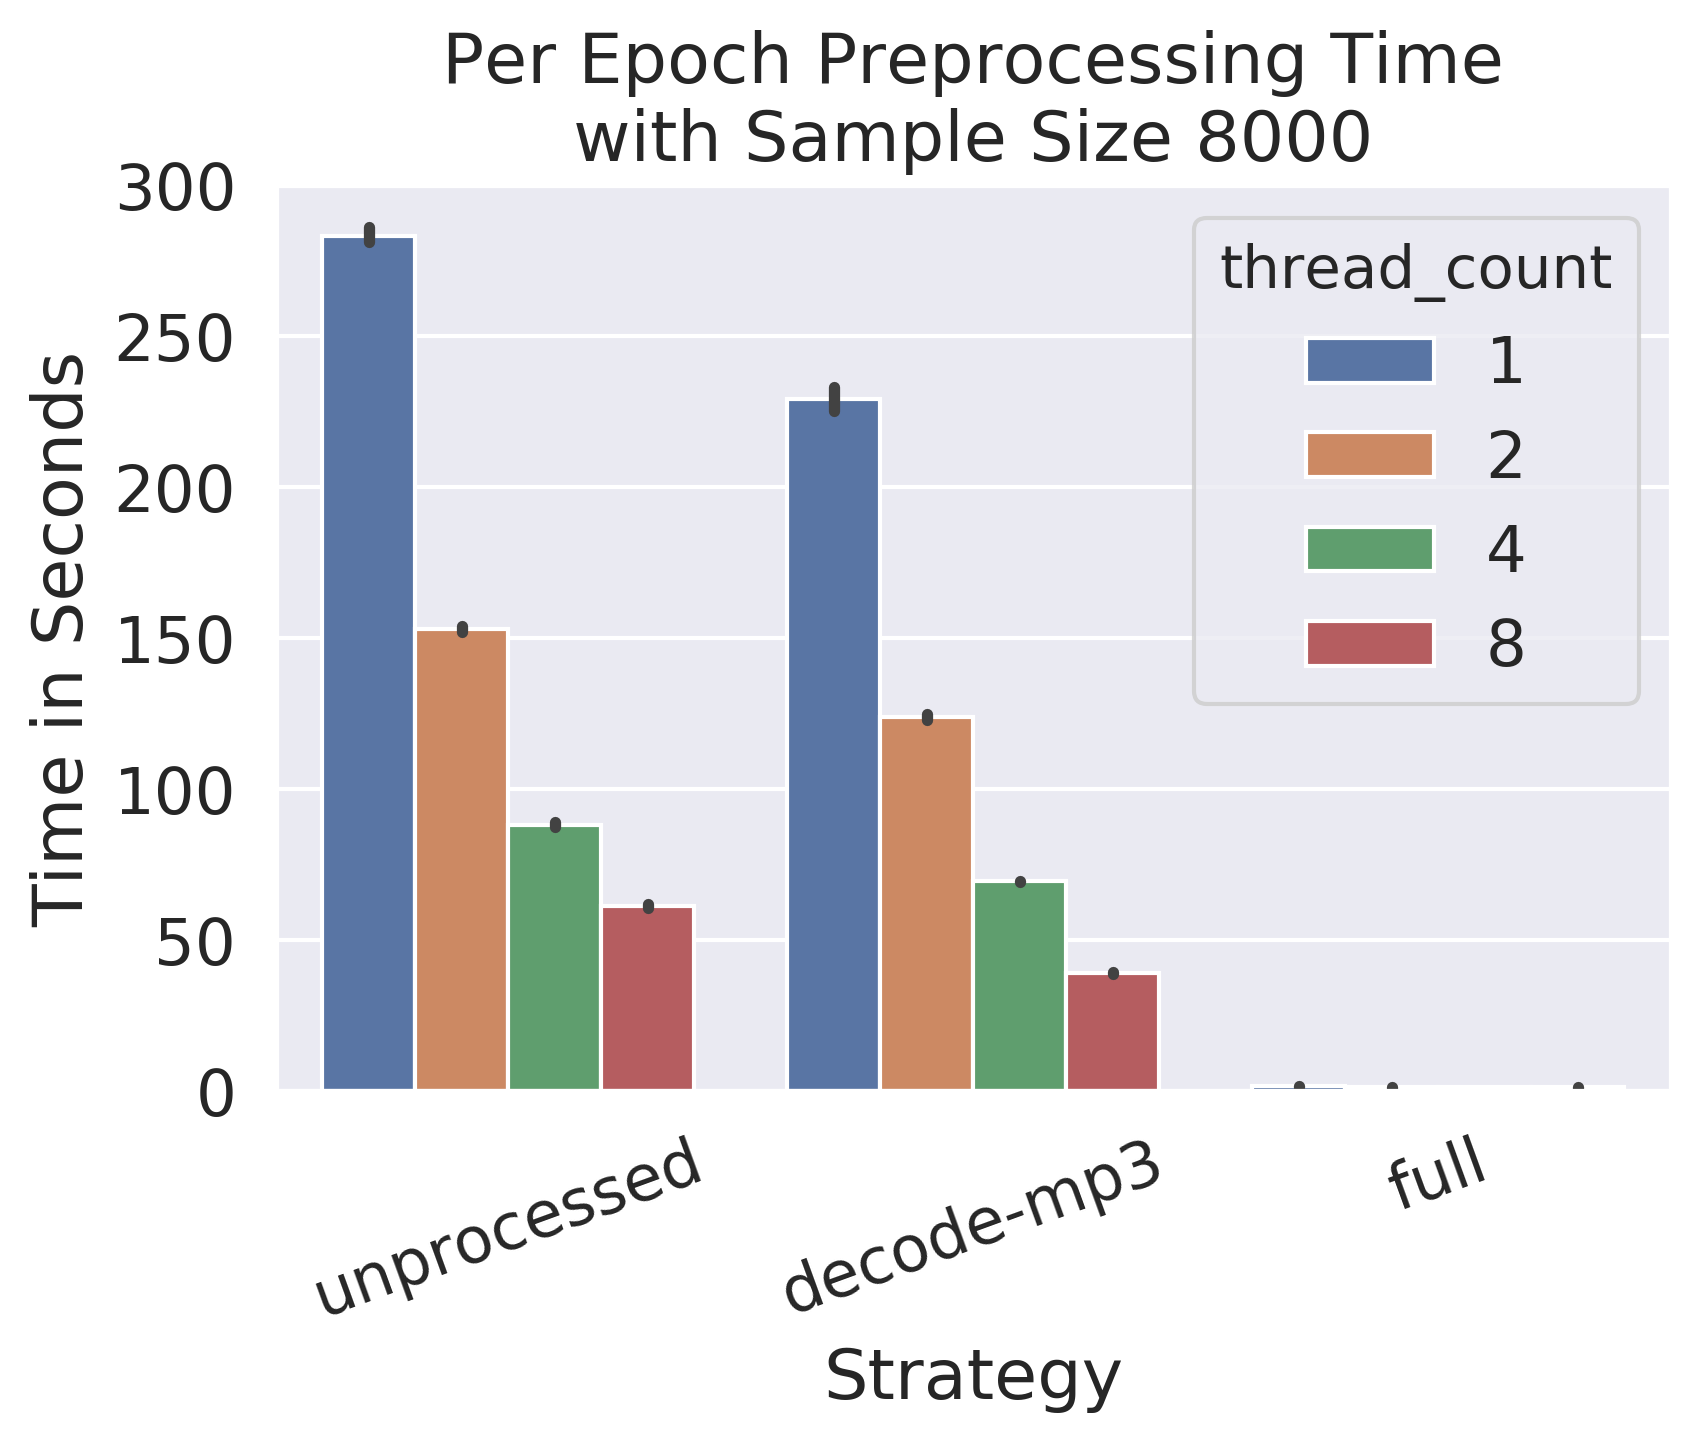

In [7]:
plot = sns.barplot(
    x="split_name",
    y="online_processing_time_s",
    hue="thread_count",
    data=cum_df.query(f"sample_count==8000")
)
plot.set_title(f"Per Epoch Preprocessing Time\n with Sample Size 8000 {sampling_tag}")
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
plot.set(xlabel="Strategy", ylabel="Time in Seconds")
plot.set(ylim=(0, 300))

[(0, 300)]

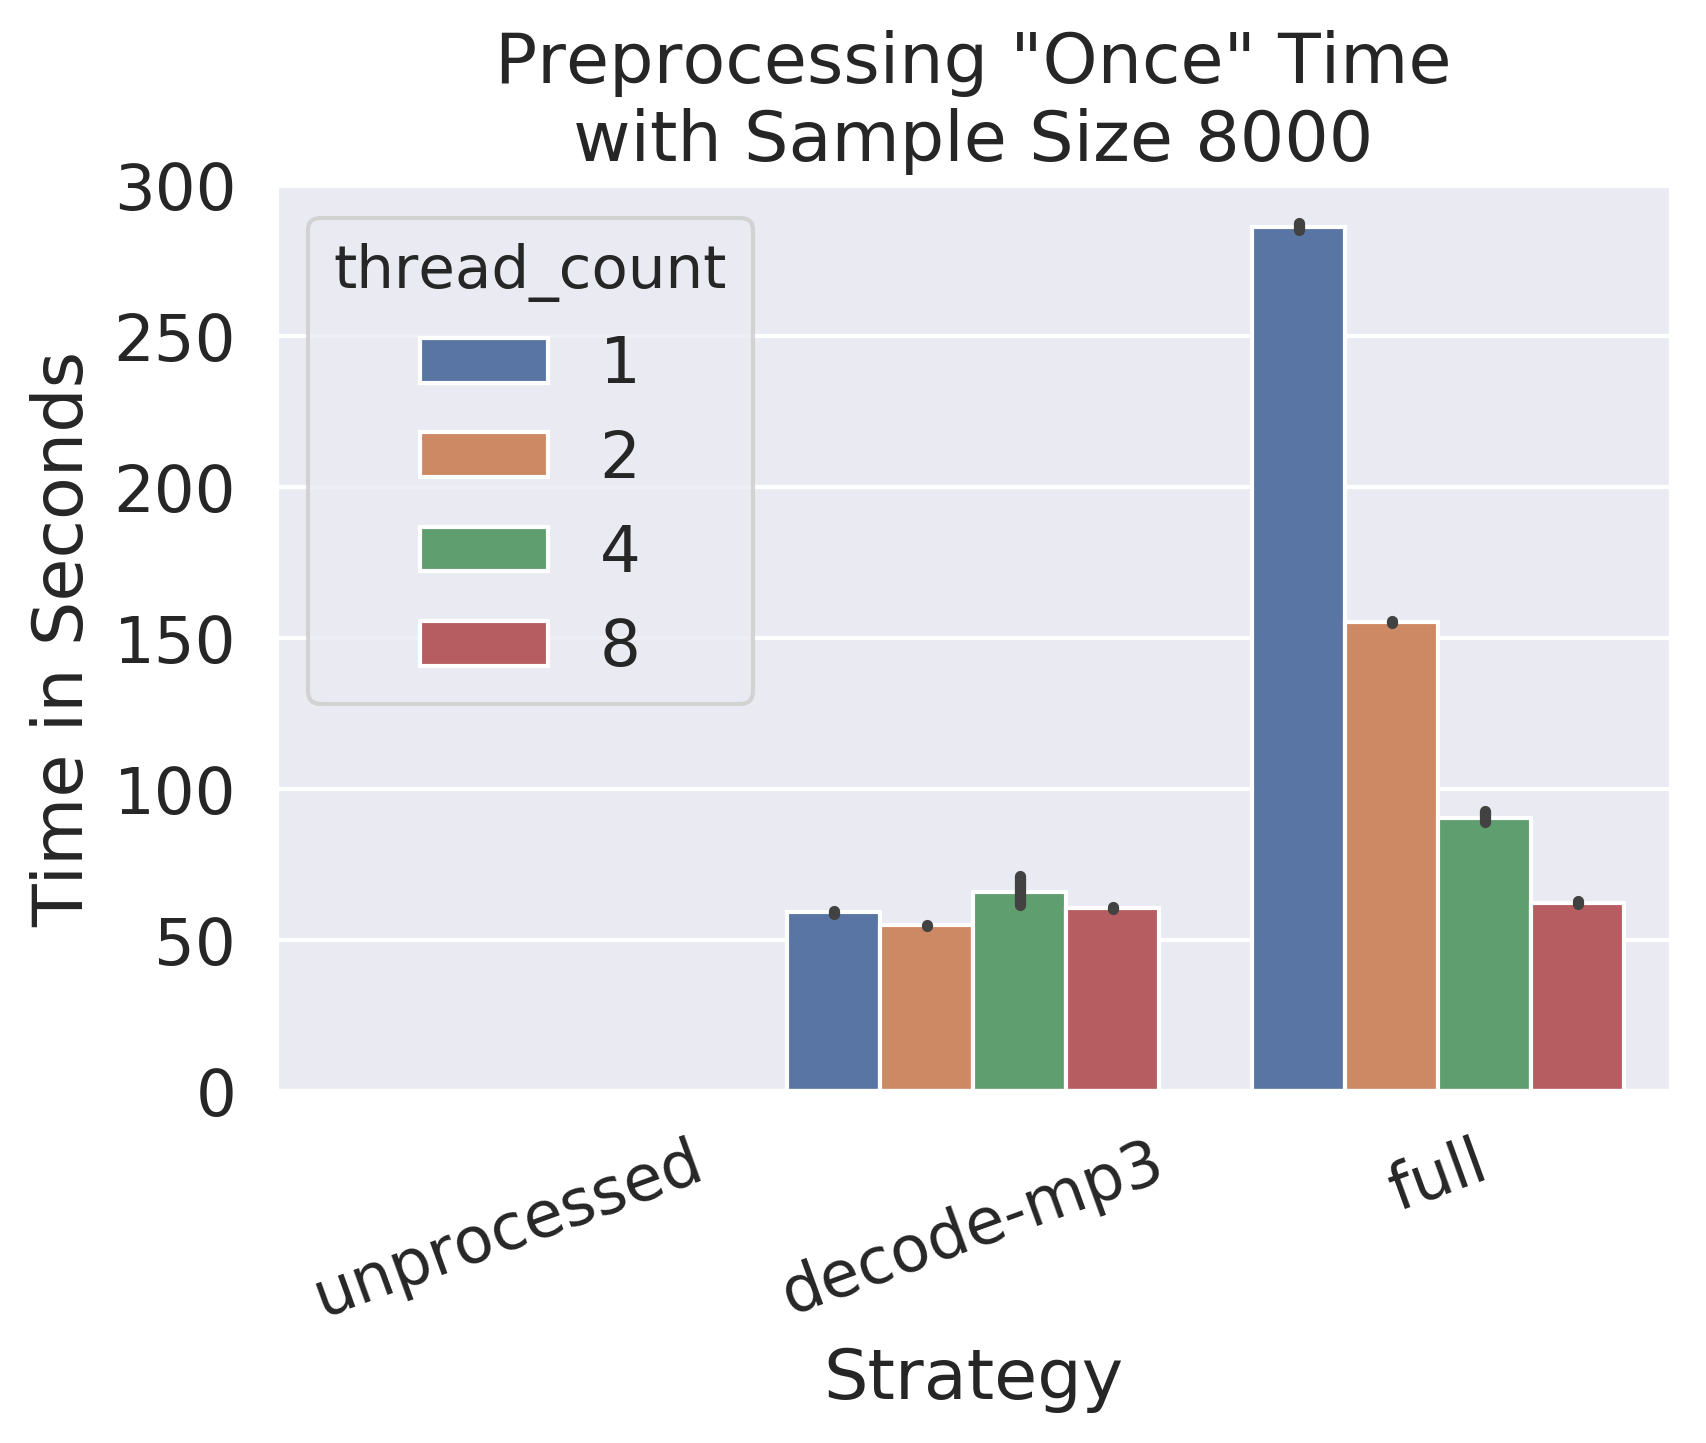

In [8]:
plot = sns.barplot(
    x="split_name",
    y="offline_processing_and_save_time_s",
    hue="thread_count",
    data=cum_df.query(f"sample_count==8000")
)
plot.set_title(f"Preprocessing \"Once\" Time\n with Sample Size 8000 {sampling_tag}")
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
plot.set(xlabel="Strategy", ylabel="Time in Seconds")
plot.set(ylim=(0, 300))

## 2.2 Unmarshalling Cost for Last Data Representation

[Text(0, 0.5, 'Time in Seconds'), Text(0.5, 0, 'Sample Count')]

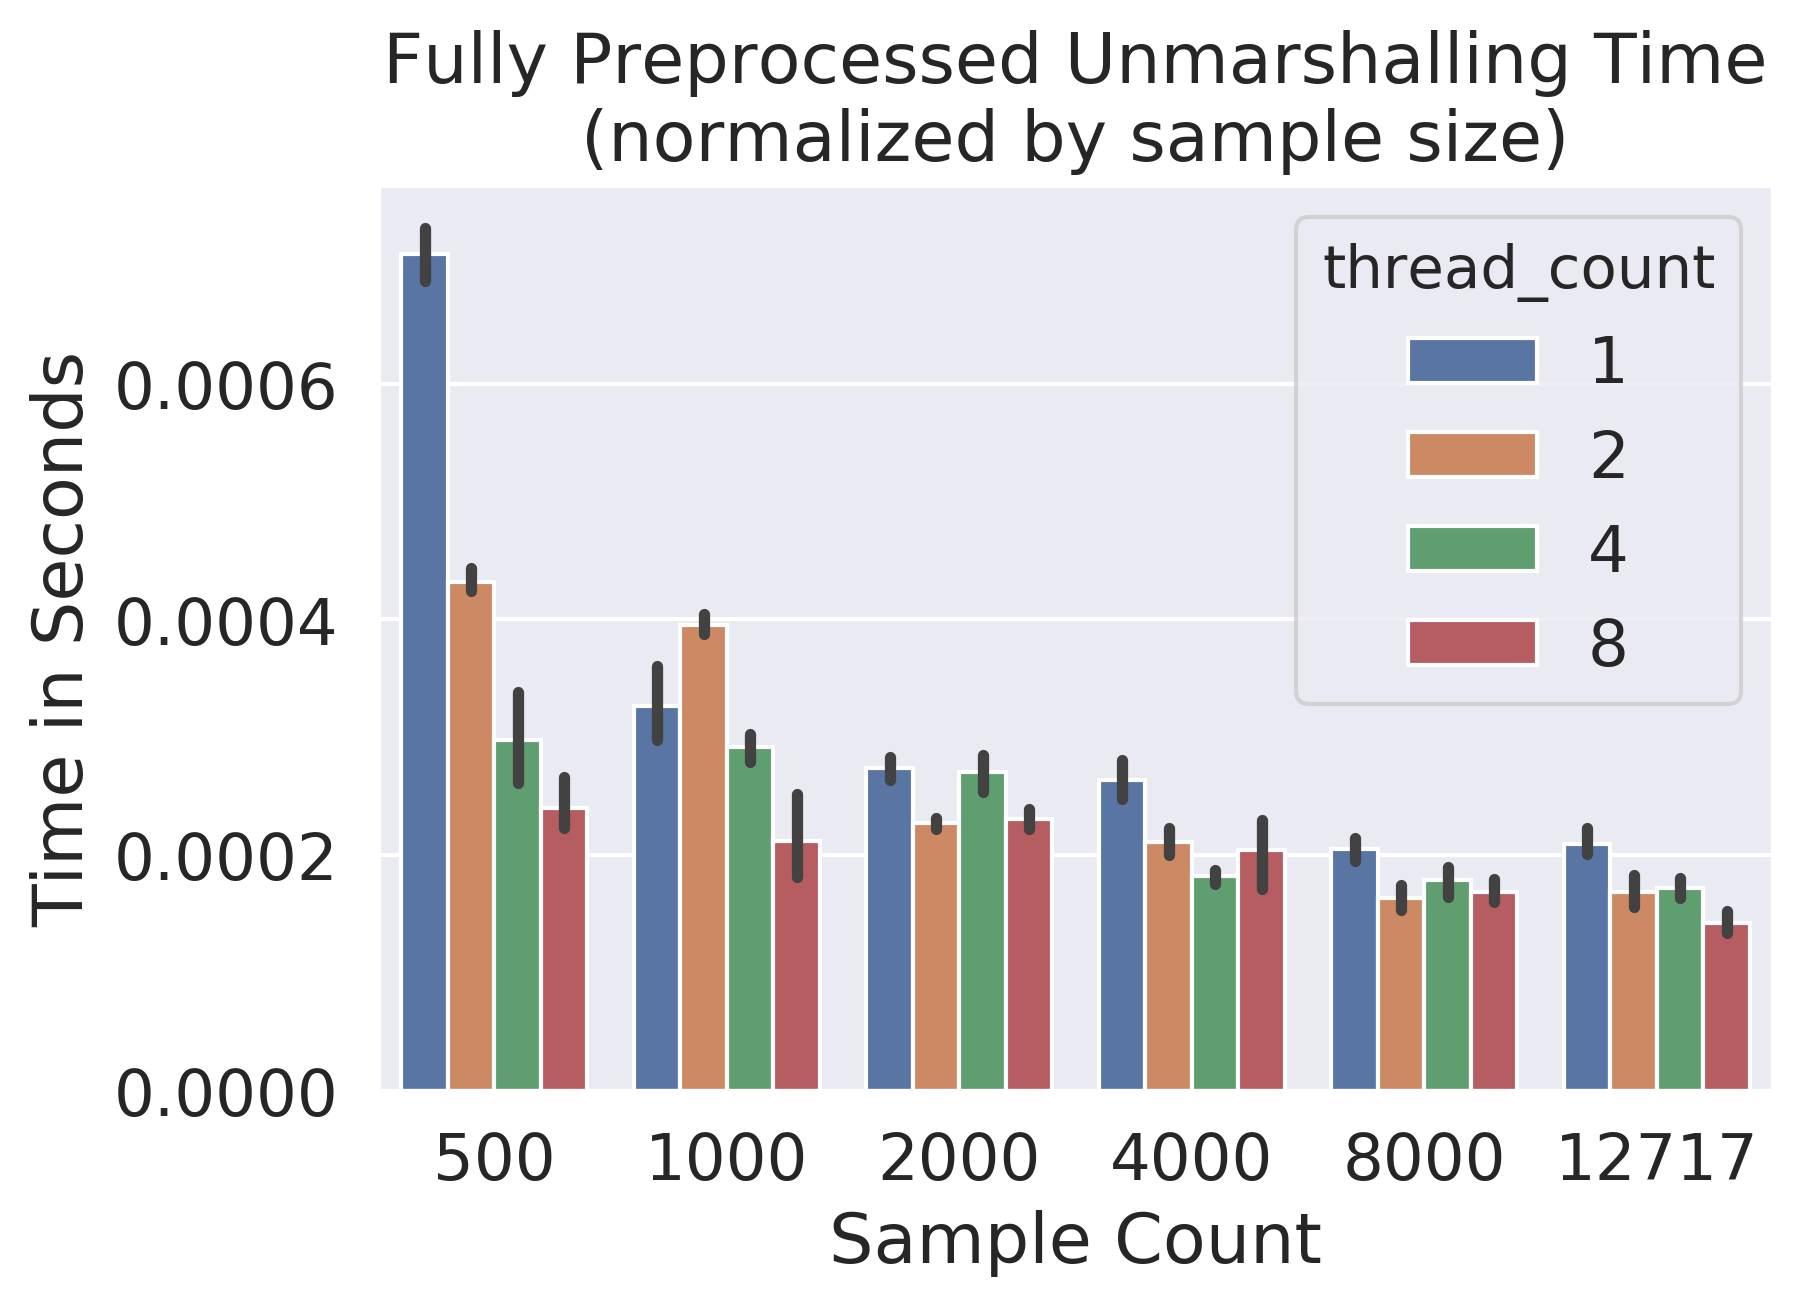

In [9]:
test_df = cum_df.copy(deep=True)
test_df["normalized_online_processing_time_s"] = test_df["online_processing_time_s"] / test_df["sample_count"]

plot = sns.barplot(
    x="sample_count",
    y="normalized_online_processing_time_s",
    hue="thread_count",
    data=test_df.query(f"split_name=='{strategies[-1]}'")
)
plot.set_title(f"Fully Preprocessed Unmarshalling Time\n(normalized by sample size){sampling_tag}")
plot.set(xlabel="Sample Count", ylabel="Time in Seconds")
#plot.set(ylim=(0,1.4))

# 3. Throughput Analysis

## 3.1 Throughput (sample_count = 8000)

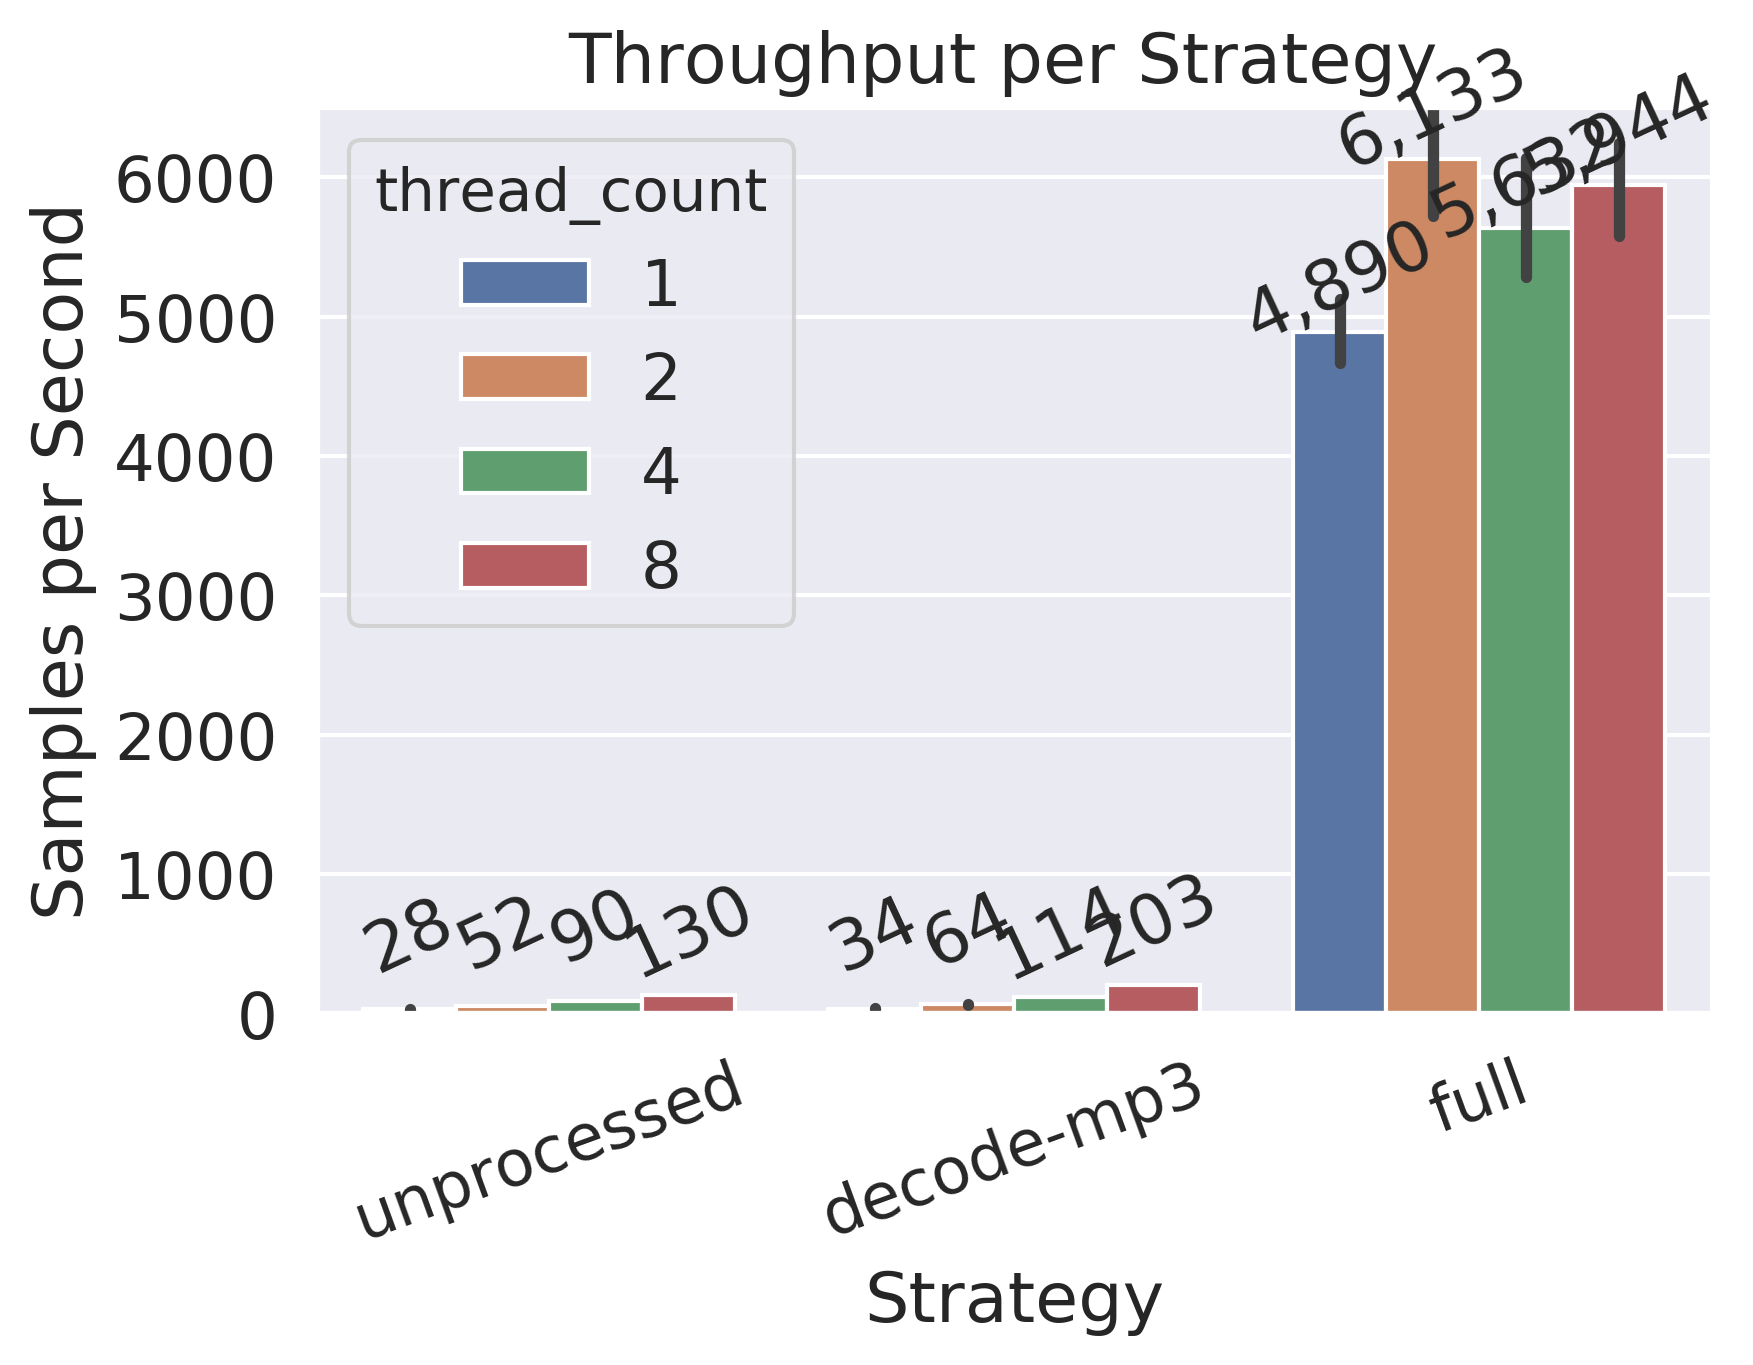

In [10]:
plot = sns.barplot(
    x="split_name",
    y="throughput_sps",
    hue="thread_count",
    data=cum_df.query(f"sample_count==8000")
)
plot.set_title(f"Throughput per Strategy {sampling_tag}")
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
plot.set(xlabel="Strategy", ylabel="Samples per Second")
plot.set(ylim=(0, 6500))

#additional_space = [-180, -105, -150, 0, 0] \
#                 + [-50, 0, 0, 0, 0] \
#                 + [60, 0, -80, 0, 0] \
#                 + [0, 0, 0, 0, 100]
show_values_on_bars(plot, space=500)#, additional_space=additional_space)

## 3.2 Parallelization capabilities (sample_count = 8000)

In [11]:
cum_8000_df = cum_df.query("sample_count==8000")

par_capability = {
      "threads": []
    , "strategy": []
    , "speedup": []
}

def add_capability(threads, strategy, speedup):
    par_capability["threads"] += [threads]
    par_capability["strategy"] += [strategy]
    par_capability["speedup"] += [speedup]

for strategy in strategies:
    for thread_count in cum_df.thread_count.unique():
        throughputs = cum_8000_df.query(f"thread_count=={thread_count} and split_name=='{strategy}'")["throughput_sps"].to_numpy()
        for throughput in throughputs:
            avg_step_t1_throughput = cum_8000_df.query(f"thread_count=={1} and split_name=='{strategy}'")["throughput_sps"].mean()
            # not using percentages here as I feel its more intuitive, benchmarking crimes is still followed from my understanding
            #if avg_step_t1_throughput < throughput:
            #    rel_increase_factor =  throughput / avg_step_t1_throughput - 1
            #    add_capability(thread_count, strategy, np.round(rel_increase_factor, 2))
            #else:
            #    rel_decrease_factor = 1 - throughput / avg_step_t1_throughput
            #    add_capability(thread_count, strategy, -np.round(rel_decrease_factor, 2))
            ## now using speedup instead of increase/decrease factor
            speedup = throughput / avg_step_t1_throughput
            add_capability(thread_count, strategy, speedup)

capability_df = pd.DataFrame(par_capability)
capability_df

,threads,strategy,speedup
0,1,0-fully-online,0.979531
1,1,0-fully-online,1.005181
2,1,0-fully-online,1.004619
3,1,0-fully-online,1.008937
4,1,0-fully-online,1.001732
5,2,0-fully-online,1.837594
6,2,0-fully-online,1.846832
7,2,0-fully-online,1.833890
8,2,0-fully-online,1.850705
9,2,0-fully-online,1.875968


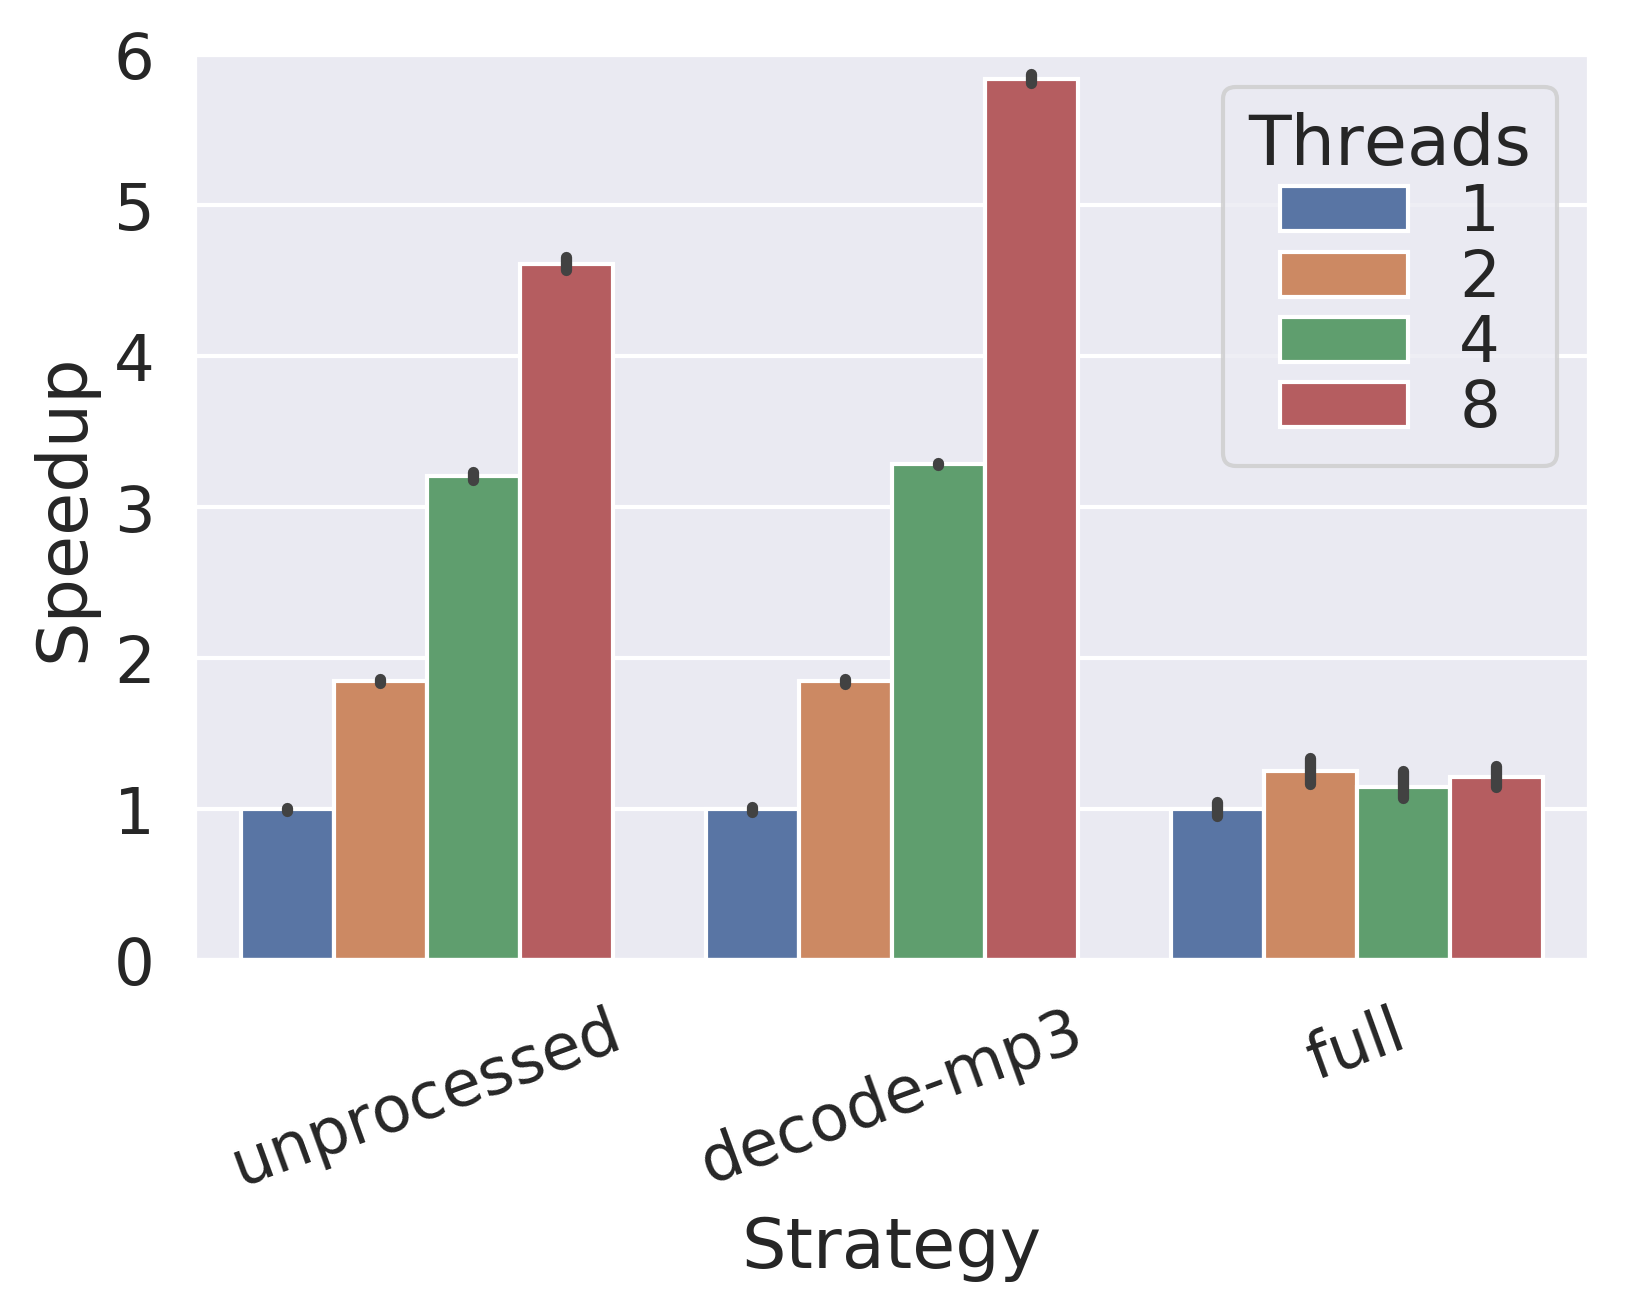

In [12]:
plot = sns.barplot(
    x="strategy",
    y="speedup",
    hue="threads",
    data=capability_df
)
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
#plot.set_title(f"Speedup for Each Strategy Compared to\n Average Single Threaded Throughput\n with a Sample Size 8000")
plot.set(xlabel="Strategy", ylabel="Speedup")
plot.set(ylim=(0, 6))
plot.legend(title="Threads", ncol=1,labelspacing=0.05)
save_fig("speedup")

## 4. Extrapolation Capabilities

In [15]:
# calculate the per sample processing time for both offline and online processing
cum_df["per_sample_online_processing_time_s"] = cum_df["online_processing_time_s"] / cum_df["sample_count"]
cum_df["per_sample_offline_processing_and_save_time_s"] = cum_df["offline_processing_and_save_time_s"] / cum_df["sample_count"]
# calculate the total processing time for each sample count
cum_df["total_processing_time_s"] = cum_df["online_processing_time_s"] + cum_df["offline_processing_and_save_time_s"]
# extrapolate based on the full count of images
cum_df["full_dataset_online_processing_time_s"] = cum_df["per_sample_online_processing_time_s"] * full_dataset_filecount
cum_df["full_dataset_offline_processing_and_save_time_s"] = cum_df["per_sample_offline_processing_and_save_time_s"] * full_dataset_filecount
cum_df["full_dataset_offline_processing_and_save_time_m"] = cum_df["full_dataset_offline_processing_and_save_time_s"] / 60
# sum the offline and online time for the full dataset processing time (converted to hours)
cum_df["full_dataset_processing_time_s"] = cum_df["full_dataset_online_processing_time_s"] + cum_df["full_dataset_offline_processing_and_save_time_s"]
cum_df["full_dataset_processing_time_m"] = cum_df["full_dataset_processing_time_s"] / 60 

cum_df_mod = cum_df.copy(deep=True)
cum_df_mod.loc[cum_df_mod.sample_count == 12717, 'sample_count'] = '13K (full)'
order_dict = { 500: 10, 1000: 11, 2000: 12, 4000: 13, 8000: 14, '13K (full)': 15}
strategy_order_dict = dict(list(enumerate(strategies)))
strategy_order_dict = dict({(y, x) for x, y in strategy_order_dict.items()})
order_dict.update(strategy_order_dict)
cum_df_mod = cum_df_mod.sort_values(by=['split_name', 'sample_count'], key=lambda x: x.map(order_dict))
cum_df_mod

,offline_processing_and_save_time_s,shard_count,thread_count,shard_cum_size_MB,sample_count,online_processing_time_s,throughput_sps,runs_count,runs_total,ueid,split_name,creation_timestamp,per_sample_online_processing_time_s,per_sample_offline_processing_and_save_time_s,total_processing_time_s,full_dataset_online_processing_time_s,full_dataset_offline_processing_and_save_time_s,full_dataset_offline_processing_and_save_time_m,full_dataset_processing_time_s,full_dataset_processing_time_m
0,0.000000,1,1,0.000000,500,21.963967,22.764558,0,5,0725be,0-fully-online,2021-04-19-16:21:24,0.043928,0.000000,21.963967,558.631533,0.000000,0.000000,558.631533,9.310526
1,0.000000,1,1,0.000000,500,18.655786,26.801337,1,5,0725be,0-fully-online,2021-04-19-16:21:24,0.037312,0.000000,18.655786,474.491250,0.000000,0.000000,474.491250,7.908187
2,0.000000,1,1,0.000000,500,18.988259,26.332061,2,5,0725be,0-fully-online,2021-04-19-16:21:24,0.037977,0.000000,18.988259,482.947381,0.000000,0.000000,482.947381,8.049123
3,0.000000,1,1,0.000000,500,18.742784,26.676934,3,5,0725be,0-fully-online,2021-04-19-16:21:24,0.037486,0.000000,18.742784,476.703963,0.000000,0.000000,476.703963,7.945066
4,0.000000,1,1,0.000000,500,19.672406,25.416311,4,5,0725be,0-fully-online,2021-04-19-16:21:24,0.039345,0.000000,19.672406,500.347979,0.000000,0.000000,500.347979,8.339133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,100.178901,8,8,991.301574,13K (full),1.653995,7688.658902,0,5,a5807a,3-convert-to-spectrogram,2021-04-20-01:41:14,0.000130,0.007878,101.832896,1.653995,100.178901,1.669648,101.832896,1.697215
356,98.409855,8,8,990.980945,13K (full),1.743245,7295.014384,1,5,a5807a,3-convert-to-spectrogram,2021-04-20-01:41:14,0.000137,0.007738,100.153100,1.743245,98.409855,1.640164,100.153100,1.669218
357,100.704193,8,8,991.988931,13K (full),2.047496,6211.002347,2,5,a5807a,3-convert-to-spectrogram,2021-04-20-01:41:14,0.000161,0.007919,102.751688,2.047496,100.704193,1.678403,102.751688,1.712528
358,100.455466,8,8,994.367825,13K (full),1.800715,7062.195793,3,5,a5807a,3-convert-to-spectrogram,2021-04-20-01:41:14,0.000142,0.007899,102.256181,1.800715,100.455466,1.674258,102.256181,1.704270


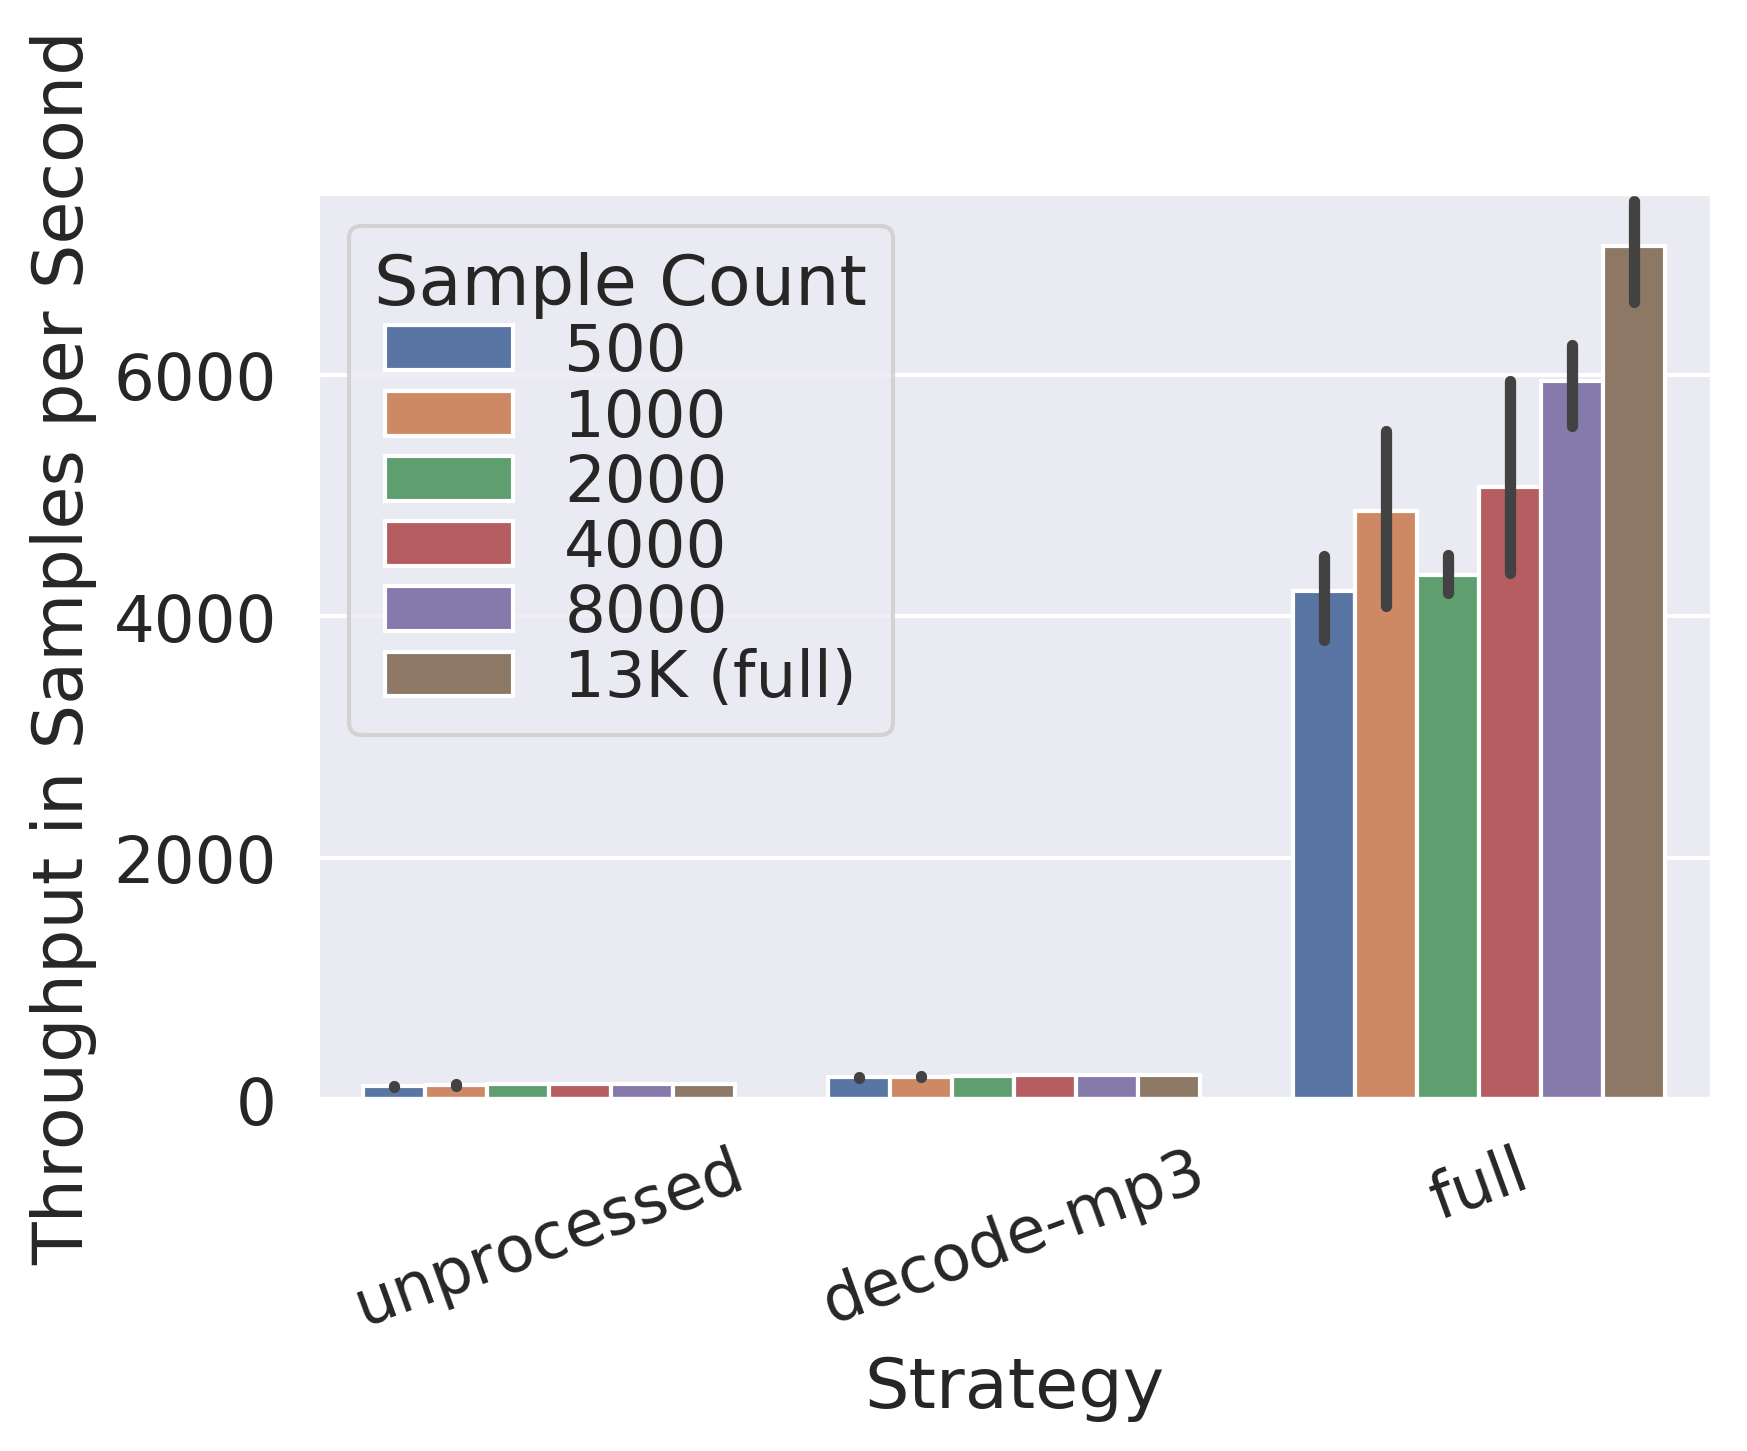

In [16]:
plot = sns.barplot(
    x="split_name",
    y="throughput_sps",
    hue="sample_count",
    data=cum_df_mod.query(f"thread_count==8")
)
#plot.set_title(f"Throughput per Strategy with 8 Threads\n{sampling_tag}")
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
plot.set(xlabel="Strategy", ylabel="Throughput in Samples per Second")
plot.set(ylim=(0, 7500))
plot.legend(title="Sample Count", ncol=1,labelspacing=0.05)
save_fig("throughput")

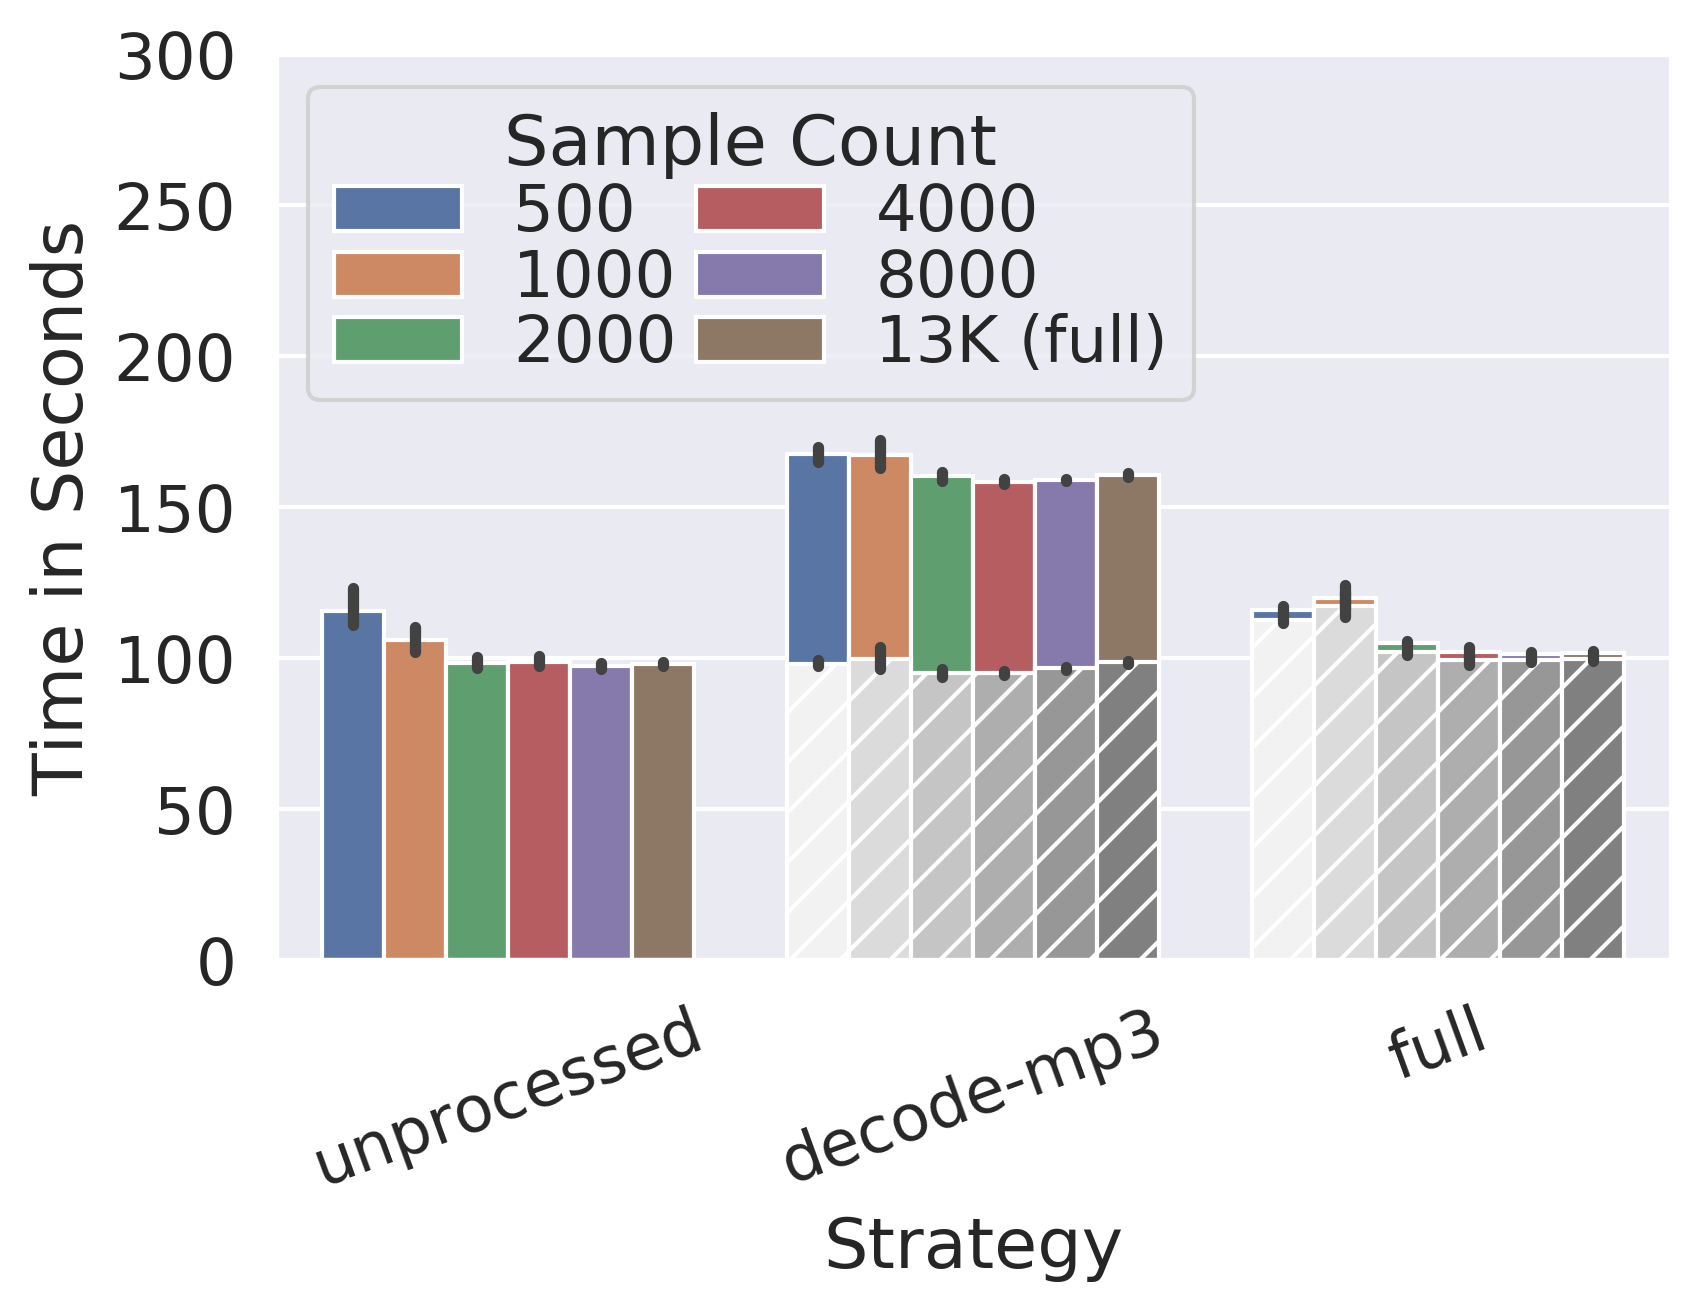

In [17]:
plot = sns.barplot(
    x="split_name",
    y="full_dataset_processing_time_s",
    hue="sample_count",
    data=cum_df_mod.query(f"thread_count==8")
)
plot = sns.barplot(
    x="split_name",
    y="full_dataset_offline_processing_and_save_time_s",
    hue="sample_count",
    data=cum_df_mod.query(f"thread_count==8"),
    color="grey"
)
sns.set(font_scale=1.4)

sample_counts = len([500, 1000, 2000, 4000, 8000, '13K (full)']) 
bars_to_skip = sample_counts * len(strategies)
hatches = ['//'] * bars_to_skip
for i,bar in enumerate(plot.patches[bars_to_skip:]):
    bar.set_hatch(hatches[i])

#plot.set_title(f"Per Epoch Per Sample Processing Time\n for Each Strategy with 8 Threads{sampling_tag}")
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
plot.set(xlabel="Strategy", ylabel="Time in Seconds")
plot.set(ylim=(0, 300))

handles, labels = plot.get_legend_handles_labels()
plot.legend(handles=handles[:sample_counts], title="Sample Count", loc="upper left", ncol=2, labelspacing=0.05, columnspacing=0.3)
save_fig("full-processing-time")

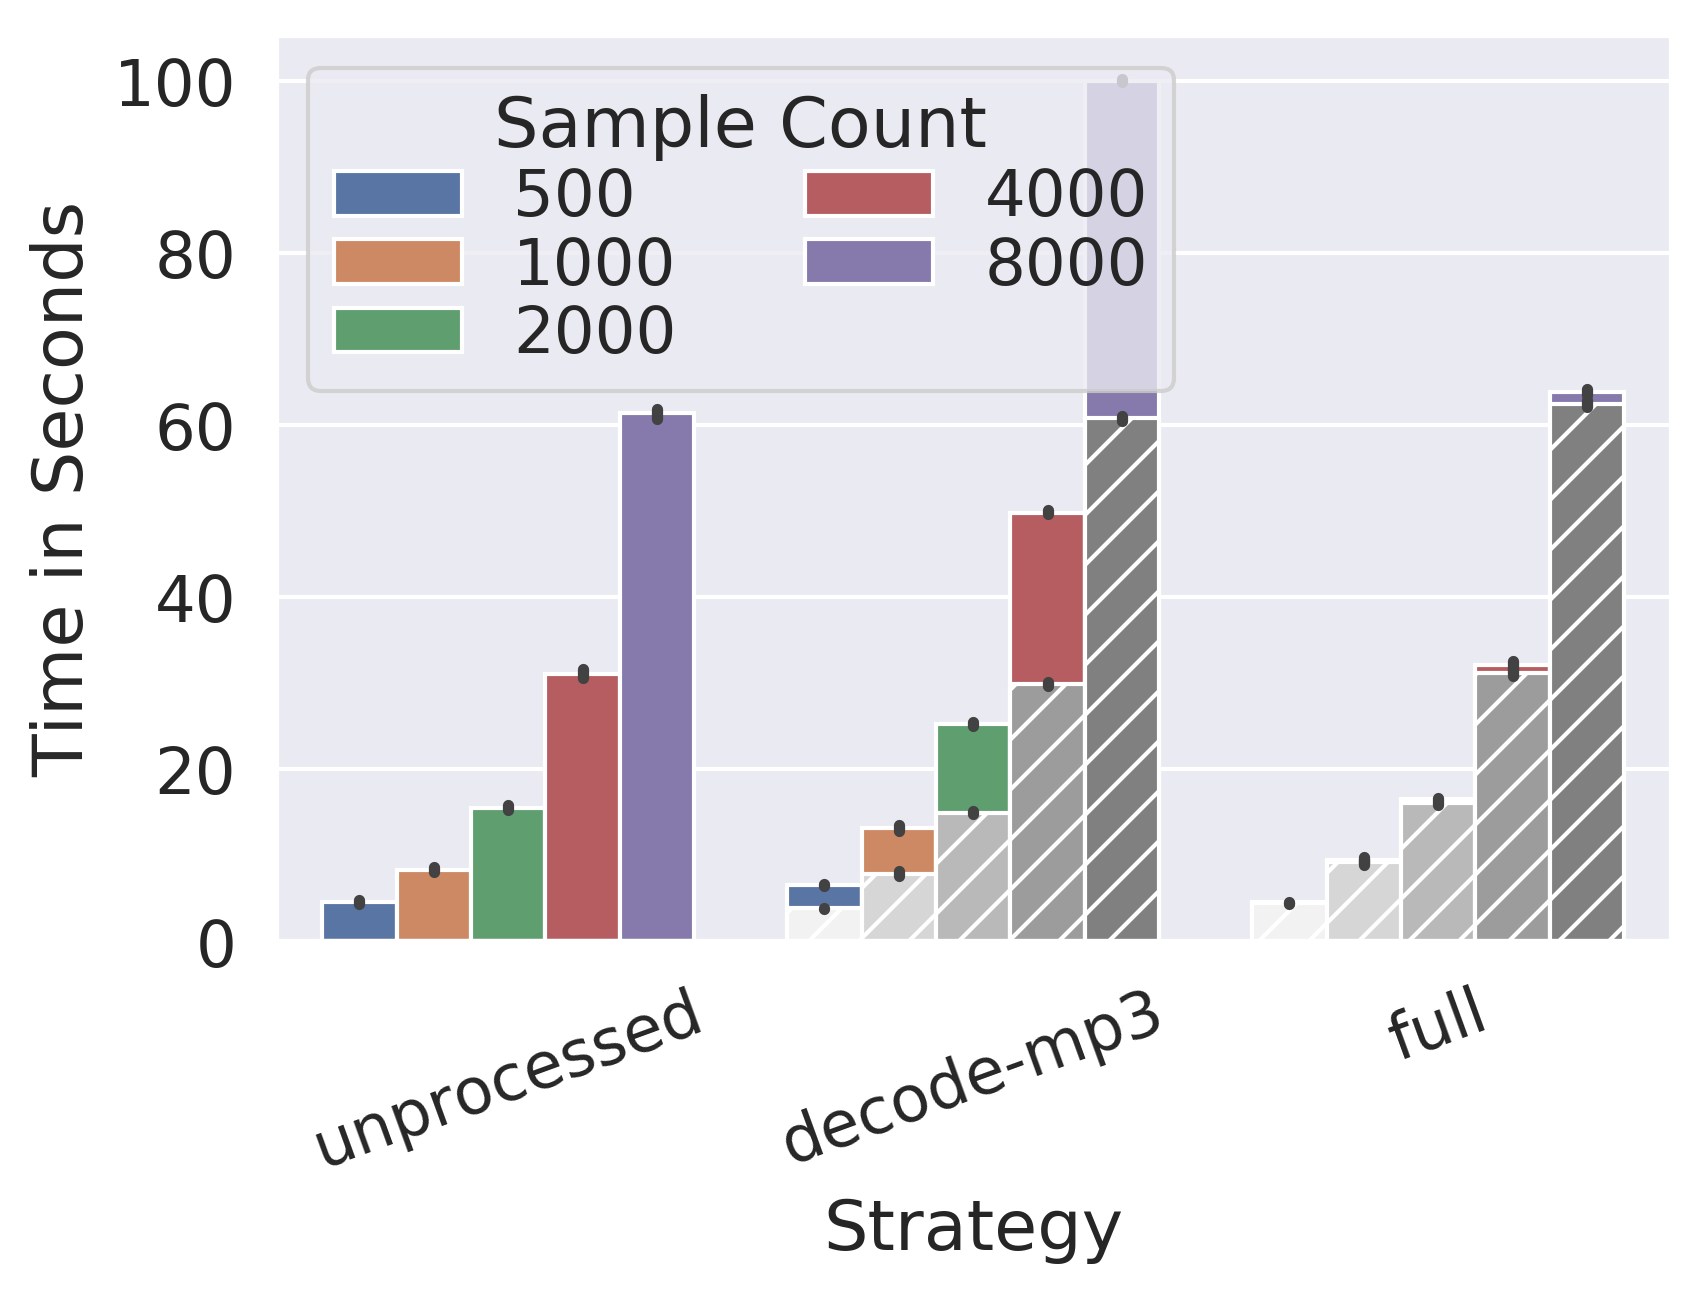

In [18]:
cum_df_preprocessing_time_comparison = cum_df_mod.query(f"thread_count==8 and sample_count!='13K (full)'")

plot = sns.barplot(
    x="split_name",
    y="total_processing_time_s",
    hue="sample_count",
    data=cum_df_preprocessing_time_comparison
)
plot = sns.barplot(
    x="split_name",
    y="offline_processing_and_save_time_s",
    hue="sample_count",
    data=cum_df_preprocessing_time_comparison,
    color="grey"
)

sample_counts = len([500, 1000, 2000, 4000, 8000])
bars_to_skip = sample_counts * len(strategies)
hatches = ['//'] * bars_to_skip
for i,bar in enumerate(plot.patches[bars_to_skip:]):
    bar.set_hatch(hatches[i])

#plot.set_title(f"Per Epoch Per Sample Processing Time\n for Each Strategy with 8 Threads{sampling_tag}")
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
plot.set(xlabel="Strategy", ylabel="Time in Seconds")
#plot.set(ylim=(0, 27))

handles, labels = plot.get_legend_handles_labels()
plot.legend(handles=handles[:sample_counts], title="Sample Count", loc="upper left", ncol=2, labelspacing=0.10)
save_fig("processing-time-per-sample-count")

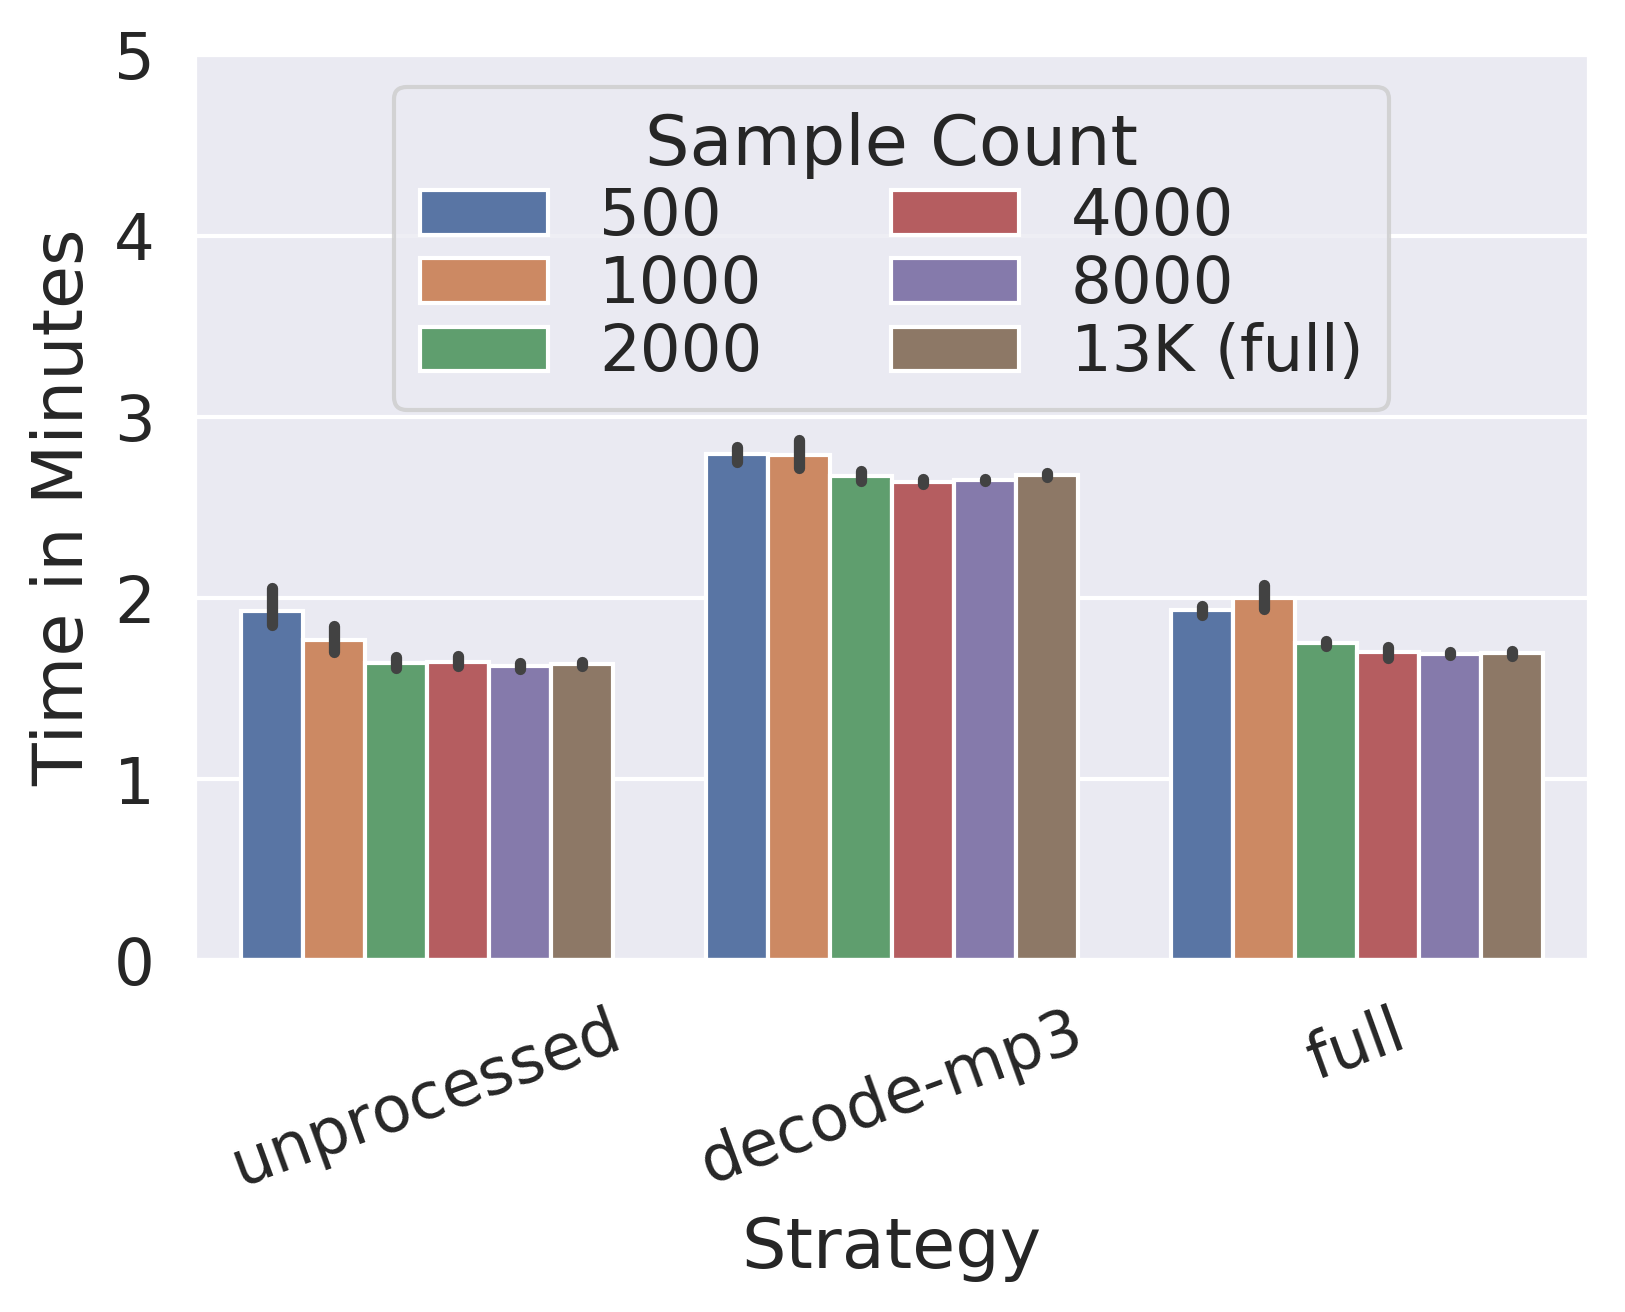

In [19]:
plot = sns.barplot(
    x="split_name",
    y="full_dataset_processing_time_m",
    hue="sample_count",
    data=cum_df_mod.query(f"thread_count==8")
)
#plot.set_title(f"Extrapolated Full Dataset Processing Time\n for Each Strategy with 8 Threads {sampling_tag}")
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
plot.set(xlabel="Strategy", ylabel="Time in Minutes")
plot.set(ylim=(0, 5))
plot.legend(title="Sample Count", loc="upper center", ncol=2,labelspacing=0.10)
#save_fig("full-processing-time")

# Warning - Creating the plots based on `dstat` logs can take several hours

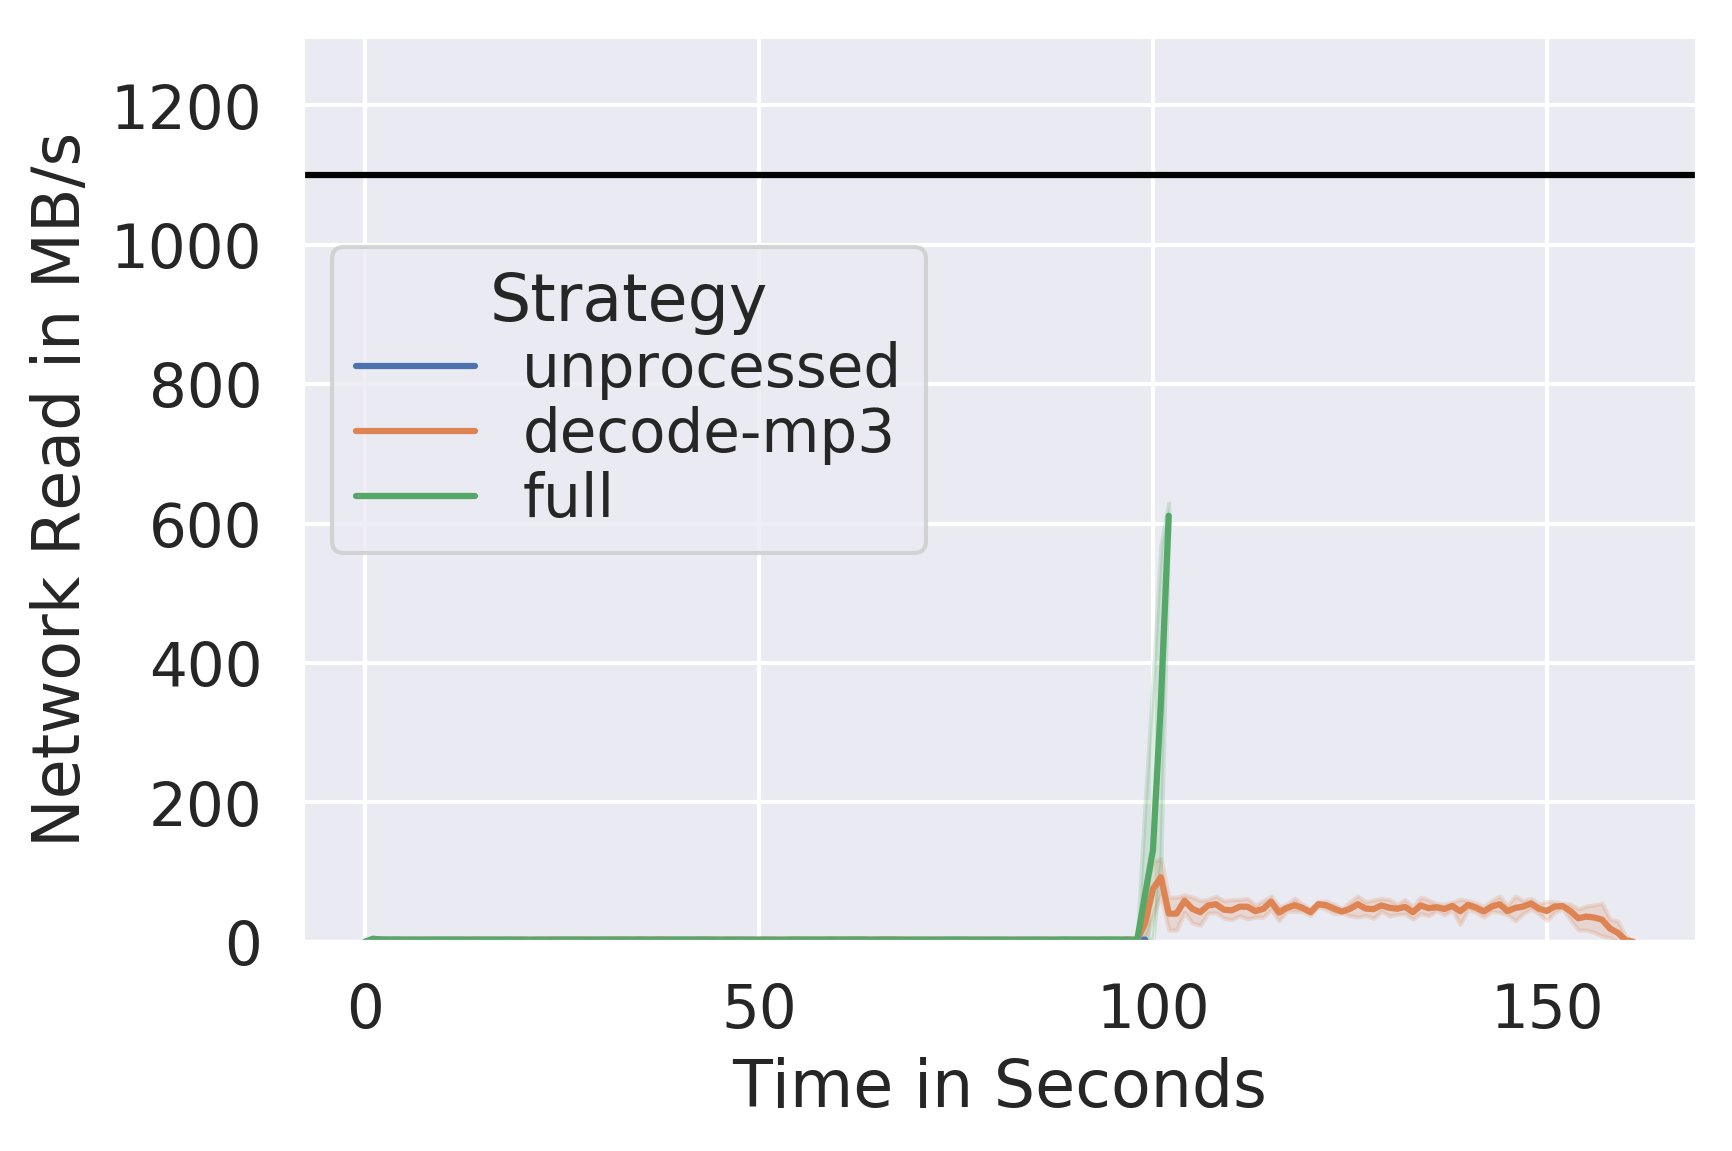

In [20]:
sns.set(font_scale=1.3)
test_df = cum_dstat_df.query(f"sample_count=={full_dataset_filecount}").copy(deep=True)
test_df["sample_count"] = test_df.sample_count.astype('category')
test_df["split_name"] = test_df.split_name.astype('category')
test_df["thread_count"] = test_df.thread_count.astype('category')
plot = sns.lineplot(
    x="rel_time_s",
    y="net_read_mbs",
    hue="split_name",
    data=test_df.query("thread_count==8"),
    ci=95
)
plot.set(xlabel="Time in Seconds", ylabel="Network Read in MB/s")
plot.set(ylim=(0, 1300))
plot.axhline(1100, color="black")
plot.legend(strategies_renamed, title="Strategy", loc="upper left", bbox_to_anchor=(0,0.8), ncol=1,labelspacing=0.10)
save_fig("network-read-speed-t8-full", file_type="png")

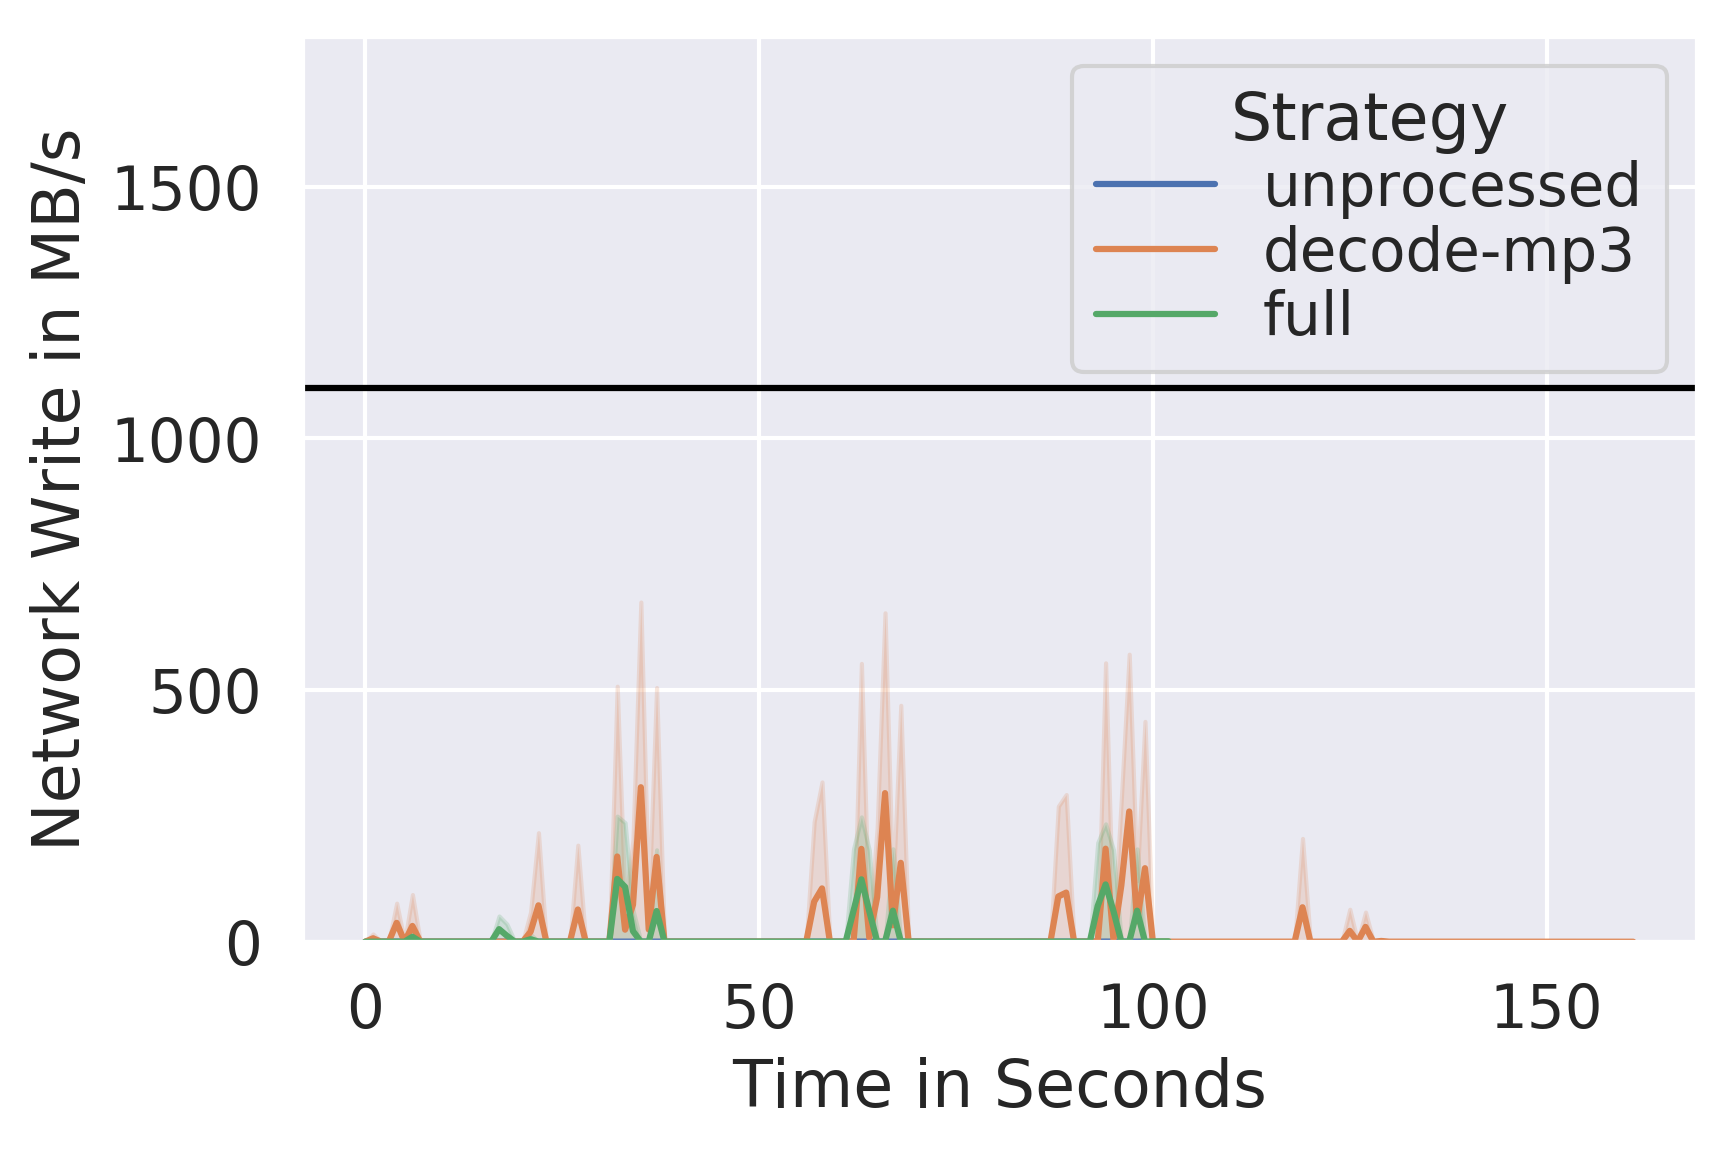

In [21]:
sns.set(font_scale=1.3)
test_df = cum_dstat_df.query(f"sample_count=={full_dataset_filecount}").copy(deep=True)
test_df["sample_count"] = test_df.sample_count.astype('category')
test_df["split_name"] = test_df.split_name.astype('category')
test_df["thread_count"] = test_df.thread_count.astype('category')
plot = sns.lineplot(
    x="rel_time_s",
    y="net_write_mbs",
    hue="split_name",
    data=test_df.query("thread_count==8"),
    ci=95
)
plot.set(xlabel="Time in Seconds", ylabel="Network Write in MB/s")
plot.set(ylim=(0, 1800))
plot.axhline(1100, color="black")
plot.legend(strategies_renamed, title="Strategy", loc="upper right", ncol=1,labelspacing=0.10)
save_fig("network-write-speed-t8-full", file_type="png")